# Introduction

This notebook presents a comprehensive analysis of network traffic data captured from various everyday network activities. The primary aim is to uncover the unique characteristics of different application scenarios by exploring key metrics such as data distribution, packet lengths, protocol usage, packet arrival times, and IP address relationships.

In particular, the analysis covers:
- **Video Conferencing:** Comparing applications like Zoom and Google Meet, where we observe different protocol behaviors (e.g., UDP versus TCP) and distinct packet arrival patterns.
- **Video Streaming:** Analyzing data from YouTube, which reveals a dominant packet length and a mix of transport protocols including QUIQ and UDP.
- **Audio Streaming:** Investigating Spotify traffic to understand how audio data and control signals are managed over reliable transport protocols.
- **Web Surfing:** Examining traffic from browsers (Chrome and Edge) to determine how HTTP, TLS, and QUIC play roles in user web experiences.

The notebook combines theoretical insights from the layers model with empirical data analysis. By using functions such as `info()`, `describe()`, and visualizations like histograms, scatter plots, and heatmaps, we establish a link between high-level network concepts and practical data behavior. This approach not only enhances the understanding of network dynamics but also provides a replicable framework for future network performance investigation. <br><br>The data was recorded on our team computer, closing all the applications in the computer and using one app at a time. After that we export the traffic to csv file from wireshark and load the csv in this project without any filters.<br><br>We also analyze the main aspect of the layers because we want to know what is the uniqueness of this network traffic, so we can ignore from the background noise in the analysis and focus on the main aspects of every network traffic


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Video Conferencing:

## Zoom:

In [53]:
from datetime import datetime, timedelta

# Read the CSV file into a DataFrame
video_conference_zoom = pd.read_csv('video_conferencing_zoom.csv')

# Convert the 'Time' column to datetime with the correct format
video_conference_zoom['Time'] = pd.to_datetime(video_conference_zoom['Time'], format='%Y/%j %H:%M:%S.%f')

# Calculate the time difference from the start of the recording
start_time = video_conference_zoom['Time'].iloc[0]
video_conference_zoom['Time'] = video_conference_zoom['Time'] - start_time

# Convert the time difference to timedelta and format it
video_conference_zoom['Time'] = video_conference_zoom['Time'].apply(lambda x: timedelta(seconds=x.total_seconds()))


# Display the updated DataFrame
video_conference_zoom.head()

No.                   Time          Source     Destination Protocol  \
0    1        0 days 00:00:00  206.247.60.204        10.0.0.4      TCP   
1    2 0 days 00:00:00.005912  206.247.60.204        10.0.0.4  TLSv1.2   
2    3 0 days 00:00:00.060293        10.0.0.4  206.247.60.204      TCP   
3    4 0 days 00:00:00.070972        10.0.0.4  206.247.60.204      UDP   
4    5 0 days 00:00:00.116224  206.247.60.204        10.0.0.4      TCP   

   Length                                             Info  
0      56     443  >  64046 [ACK] Seq=1 Ack=1 Win=16 Len=0  
1      97                                 Application Data  
2      54  64046  >  443 [ACK] Seq=44 Ack=44 Win=255 Len=0  
3     144                           59139  >  8801 Len=102  
4      56   443  >  64046 [ACK] Seq=44 Ack=44 Win=16 Len=0

In [54]:
video_conference_zoom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21318 entries, 0 to 21317
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   No.          21318 non-null  int64          
 1   Time         21318 non-null  timedelta64[ns]
 2   Source       21318 non-null  object         
 3   Destination  21318 non-null  object         
 4   Protocol     21318 non-null  object         
 5   Length       21318 non-null  int64          
 6   Info         21318 non-null  object         
dtypes: int64(2), object(4), timedelta64[ns](1)
memory usage: 1.1+ MB


In [55]:
video_conference_zoom.describe()

No.                       Time        Length
count  21318.000000                      21318  21318.000000
mean   10659.500000  0 days 00:00:35.454309934    886.580871
std     6154.120855  0 days 00:00:15.312819560    409.577800
min        1.000000            0 days 00:00:00     42.000000
25%     5330.250000     0 days 00:00:25.096165    696.250000
50%    10659.500000     0 days 00:00:37.716153   1078.000000
75%    15988.750000  0 days 00:00:48.591993250   1153.000000
max    21318.000000     0 days 00:00:57.525807   4827.000000

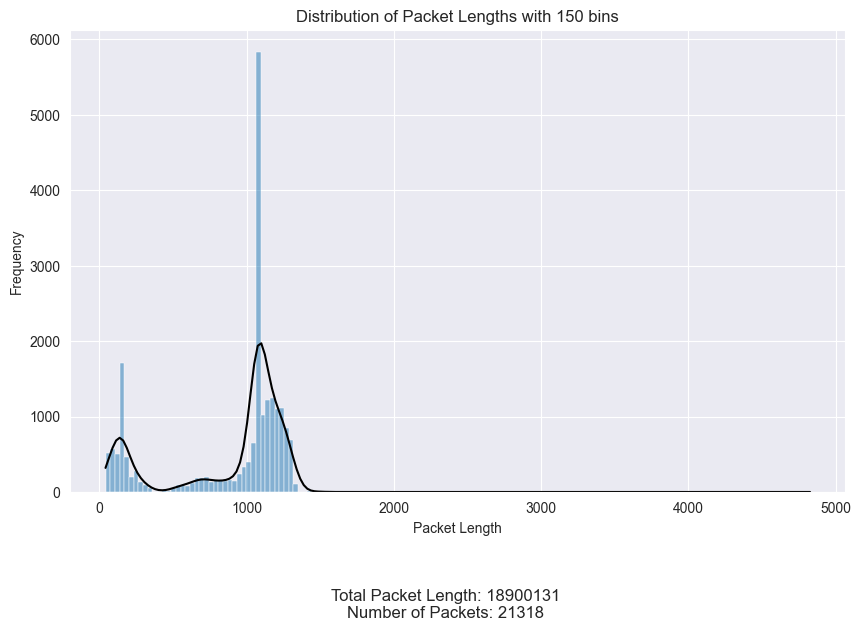

In [56]:
# Replace infinite values with NaN
video_conference_zoom.replace([float('inf'), -float('inf')], float('nan'), inplace=True)

# Calculate the total sum of packet lengths and the number of packets
total_packet_length = video_conference_zoom['Length'].sum()
number_of_packets = video_conference_zoom['Length'].count()

# Create the histogram with KDE
plt.figure(figsize=(10, 6))
ax = sns.histplot(video_conference_zoom['Length'], bins=150, kde=True)

# Set the color of the KDE line to black
for line in ax.lines:
    line.set_color('black')

plt.title('Distribution of Packet Lengths with 150 bins')
plt.xlabel('Packet Length')
plt.ylabel('Frequency')

# Add text below the plot
plt.figtext(0.5, -0.1, f'Total Packet Length: {int(total_packet_length)}\nNumber of Packets: {number_of_packets}',
            ha='center', fontsize=12)

plt.show()

We can see that the most packets are between 1000-1500 bytes, which might be the video and audio data packets, and there are some packets with a length of 0 bytes, which might be ACK packets or other control packets.

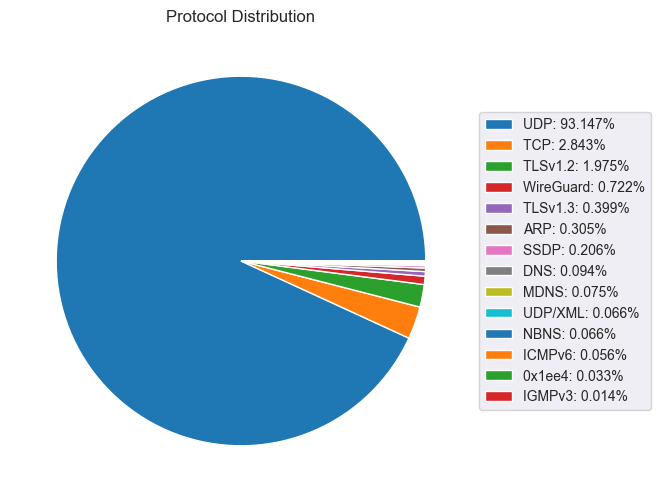

In [57]:
# Calculate protocol counts and their percentages
protocol_counts = video_conference_zoom['Protocol'].value_counts()
protocol_percentages = protocol_counts / protocol_counts.sum() * 100

# Sort the protocol counts by percentage
sorted_protocols = protocol_percentages.sort_values(ascending=False)

# Create the pie chart
plt.figure(figsize=(10, 6))
ax = sorted_protocols.plot.pie(autopct=None, labels=['']*len(sorted_protocols))

# Add a legend with sorted protocol names and percentages
legend_labels = [f'{protocol}: {percentage:.3f}%' for protocol, percentage in sorted_protocols.items()]
ax.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Protocol Distribution')
plt.ylabel('')
plt.show()

We can see that most packets are using UDP protocol that fits to transfer video and audio data, and a small percentage of packets are using TCP protocol that fits to transfer control data.

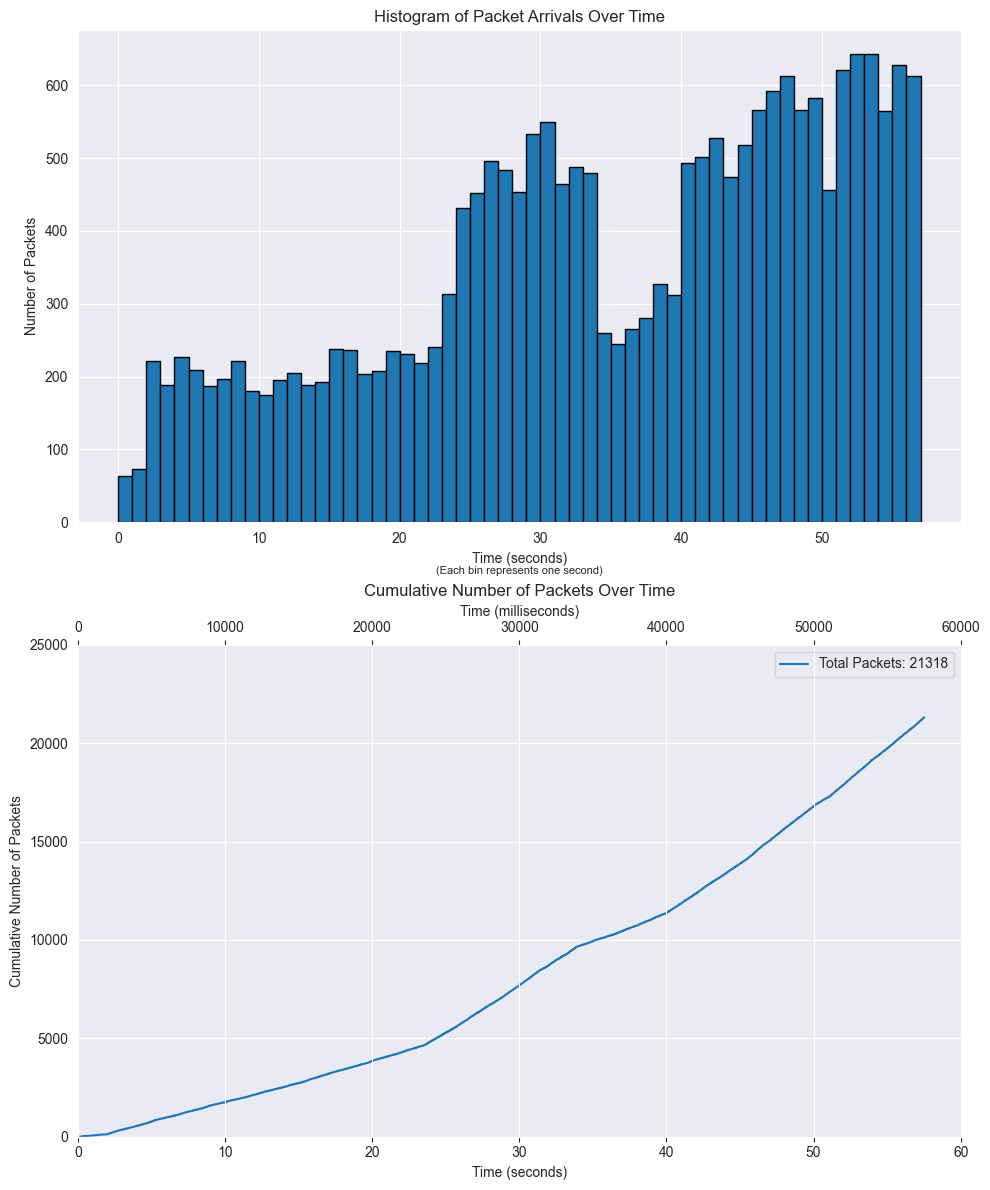

In [58]:
# Ensure 'Time' column is correctly referenced
if 'Time' in video_conference_zoom.columns:
    # Create a copy of the DataFrame for plotting
    plot_data = video_conference_zoom.copy()

    # Set the 'Time' column as the index in the copy
    plot_data.set_index('Time', inplace=True)

    # Convert 'Time' index to milliseconds and seconds
    plot_data['Time_ms'] = plot_data.index.total_seconds() * 1000
    plot_data['Time_s'] = plot_data.index.total_seconds()

    # Sort the index
    plot_data.sort_index(inplace=True)

    # Calculate the cumulative count of packets
    plot_data['Cumulative_Count'] = range(1, len(plot_data) + 1)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Plot the histogram of packet arrivals with bins of 1 second
    ax1.hist(plot_data['Time_s'], bins=range(0, int(plot_data['Time_s'].max()) + 1), edgecolor='black')
    ax1.set_title('Histogram of Packet Arrivals Over Time')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Number of Packets')
    ax1.text(0.5, -0.1, '(Each bin represents one second)', ha='center', va='center', transform=ax1.transAxes, fontsize=8)

    # Plot the cumulative count of packets
    ax2.plot(plot_data['Time_s'], plot_data['Cumulative_Count'], label='Cumulative Count')
    ax2.set_title('Cumulative Number of Packets Over Time')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Cumulative Number of Packets')
    ax2.set_xlim(0, 60)
    ax2.set_ylim(0, 25000)
    total_packets = plot_data['Cumulative_Count'].max()
    ax2.legend([f'Total Packets: {total_packets}'])

    # Create a secondary x-axis for milliseconds
    ax2_sec = ax2.twiny()
    ax2_sec.set_xlim(0, 60000)
    ax2_sec.set_xlabel('Time (milliseconds)')

    # Display the plots
    plt.tight_layout()
    plt.show()
else:
    print("The 'Time' column is not found in the DataFrame.")

We can see that the number of packets arrived in each second is not constant, and there are some seconds with a higher number of packets than others, which might be due to the nature of the video conferencing application and the data being transferred.<br>Moreover, we can see that the cumulative number of packets is increasing linearly with sudden increases, which indicates that the packets are arriving at an inconstant rate.

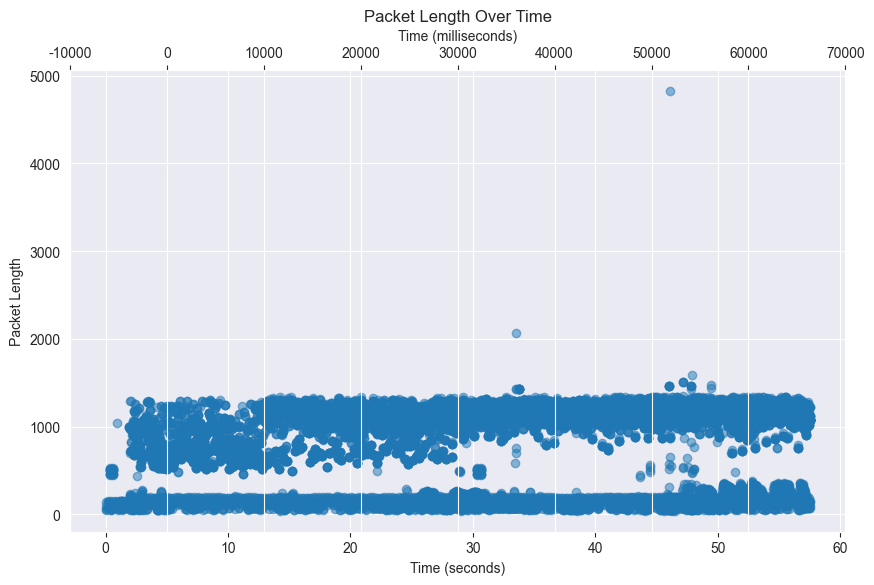

In [59]:
# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(video_conference_zoom['Time'].dt.total_seconds(), video_conference_zoom['Length'], alpha=0.5)
plt.title('Packet Length Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Packet Length')

# Create a secondary x-axis for milliseconds
ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel('Time (milliseconds)')
ax2.set_xticks(ax1.get_xticks())
ax2.set_xticklabels([int(x * 1000) for x in ax1.get_xticks()])

plt.show()

We can see that the packet length is varying over time, with most packets having a length of around 750-1500 bytes, which might be the video and audio data packets, and there are some packets with a length of 0-500 bytes, which might be ACK packets or other control packets.

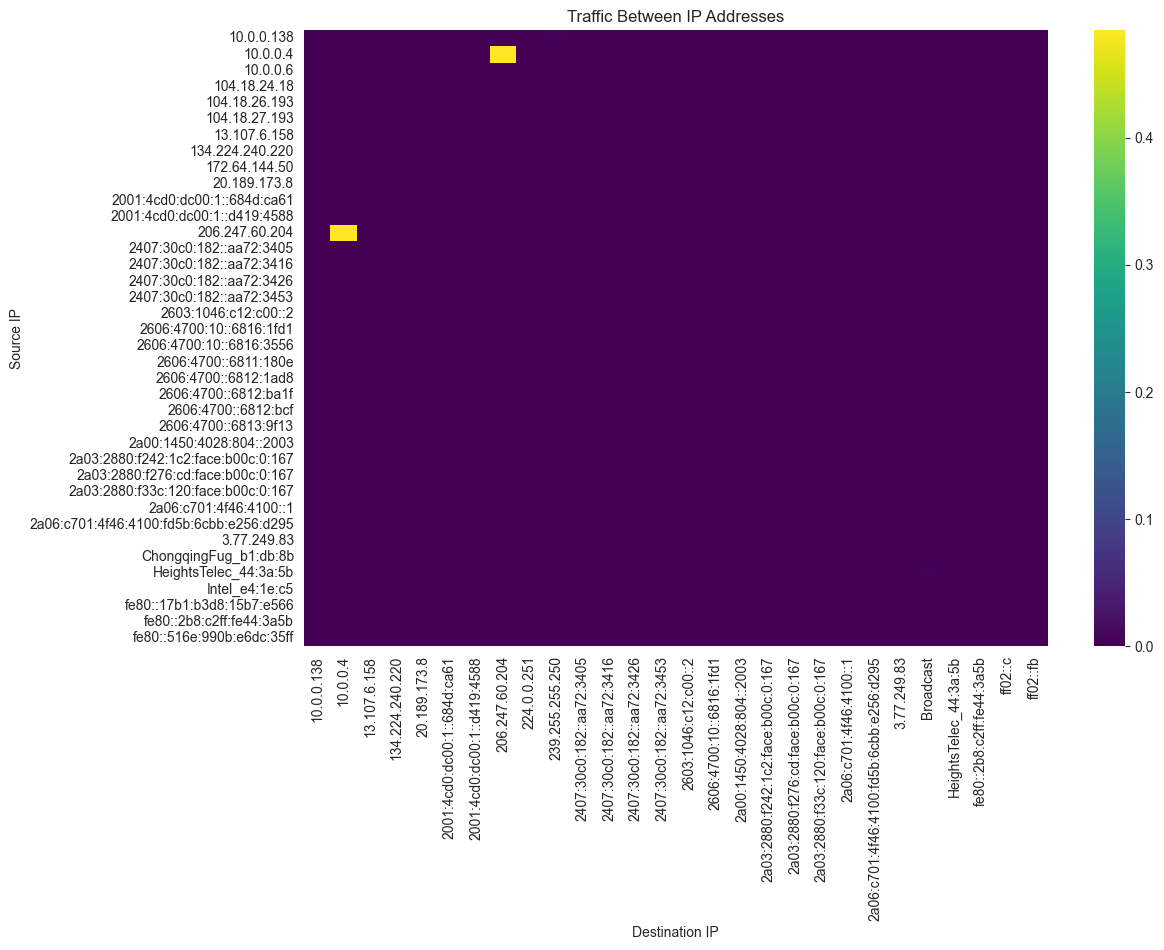

In [60]:
# Calculate the total traffic
total_traffic = video_conference_zoom.shape[0]

# Create the crosstab
heatmap_data = pd.crosstab(video_conference_zoom['Source'], video_conference_zoom['Destination'])

# Filter out addresses with traffic less than 0.01% of the total
threshold = total_traffic * 0.0001
filtered_heatmap_data = heatmap_data[heatmap_data > threshold].dropna(axis=0, how='all').dropna(axis=1, how='all')

# Calculate the ratio for each cell
ratio_heatmap_data = filtered_heatmap_data / total_traffic

# Fill NaN values with their real ratio
filled_heatmap_data = ratio_heatmap_data.fillna(0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filled_heatmap_data, cmap='viridis')
plt.title('Traffic Between IP Addresses')
plt.xlabel('Destination IP')
plt.ylabel('Source IP')
plt.show()

We can see that most of the traffic is between the same source and destination IP addresses, which is what we would expect in a video conferencing scenario where the data is exchanged between two parties.

## Google Meet:

In [61]:
from datetime import datetime, timedelta

# Read the CSV file into a DataFrame
video_conference_google_meet = pd.read_csv('video_conferencing_google_meet.csv')

# Convert the 'Time' column to datetime with the correct format
video_conference_google_meet['Time'] = pd.to_datetime(video_conference_google_meet['Time'], format='%Y/%j %H:%M:%S.%f')

# Calculate the time difference from the start of the recording
start_time = video_conference_google_meet['Time'].iloc[0]
video_conference_google_meet['Time'] = video_conference_google_meet['Time'] - start_time

# Convert the time difference to timedelta and format it
video_conference_google_meet['Time'] = video_conference_google_meet['Time'].apply(lambda x: timedelta(seconds=x.total_seconds()))

# Display the updated DataFrame
video_conference_google_meet.head()

No.                   Time                                   Source  \
0    1        0 days 00:00:00  2a06:c701:4f46:4100:5044:1cb7:1b58:317b   
1    2 0 days 00:00:00.006223  2a06:c701:4f46:4100:5044:1cb7:1b58:317b   
2    3 0 days 00:00:00.006563  2a06:c701:4f46:4100:5044:1cb7:1b58:317b   
3    4 0 days 00:00:00.006639  2a06:c701:4f46:4100:5044:1cb7:1b58:317b   
4    5 0 days 00:00:00.006716  2a06:c701:4f46:4100:5044:1cb7:1b58:317b   

                Destination Protocol  Length  \
0  2001:4860:4864:6:8000::4      TCP     188   
1  2001:4860:4864:6:8000::4      TCP    1161   
2  2001:4860:4864:6:8000::4      TCP    1161   
3  2001:4860:4864:6:8000::4      TCP    1161   
4  2001:4860:4864:6:8000::4      TCP    1161   

                                                Info  
0  56583  >  19305 [PSH, ACK] Seq=1 Ack=1 Win=507...  
1  56583  >  19305 [PSH, ACK] Seq=115 Ack=1 Win=5...  
2  56583  >  19305 [PSH, ACK] Seq=1202 Ack=1 Win=...  
3  56583  >  19305 [PSH, ACK] Seq=2289 Ack=1 Win=...  
4  56583  >  19305 [PSH, ACK] Seq=3376 Ack=1 Win=...

In [62]:
video_conference_google_meet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39130 entries, 0 to 39129
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   No.          39130 non-null  int64          
 1   Time         39130 non-null  timedelta64[ns]
 2   Source       39130 non-null  object         
 3   Destination  39130 non-null  object         
 4   Protocol     39130 non-null  object         
 5   Length       39130 non-null  int64          
 6   Info         39130 non-null  object         
dtypes: int64(2), object(4), timedelta64[ns](1)
memory usage: 2.1+ MB


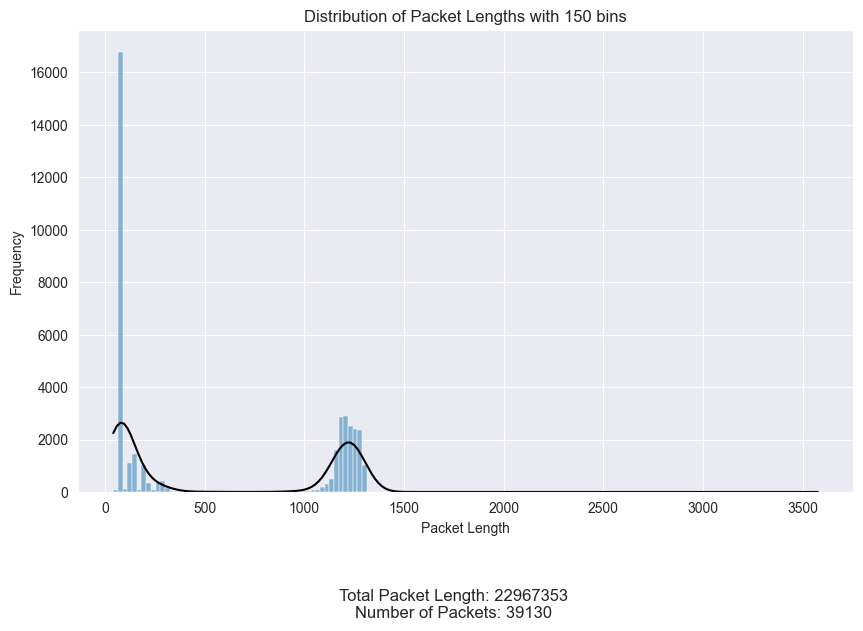

In [63]:
# Replace infinite values with NaN
video_conference_google_meet.replace([float('inf'), -float('inf')], float('nan'), inplace=True)

# Calculate the total sum of packet lengths and the number of packets
total_packet_length = video_conference_google_meet['Length'].sum()
number_of_packets = video_conference_google_meet['Length'].count()

# Create the histogram with KDE
plt.figure(figsize=(10, 6))
ax = sns.histplot(video_conference_google_meet['Length'], bins=150, kde=True)

# Set the color of the KDE line to black
for line in ax.lines:
    line.set_color('black')

plt.title('Distribution of Packet Lengths with 150 bins')
plt.xlabel('Packet Length')
plt.ylabel('Frequency')

# Add text below the plot
plt.figtext(0.5, -0.1, f'Total Packet Length: {int(total_packet_length)}\nNumber of Packets: {number_of_packets}',
            ha='center', fontsize=12)

plt.show()

We can see that the distribution of packet lengths is skewed to the left (with length of approximate up to 100 bytes), with a peak around 1000-1500 bytes. The peak around 0 to 100 bytes because the majority of packets contains ACk or small data with ACK.

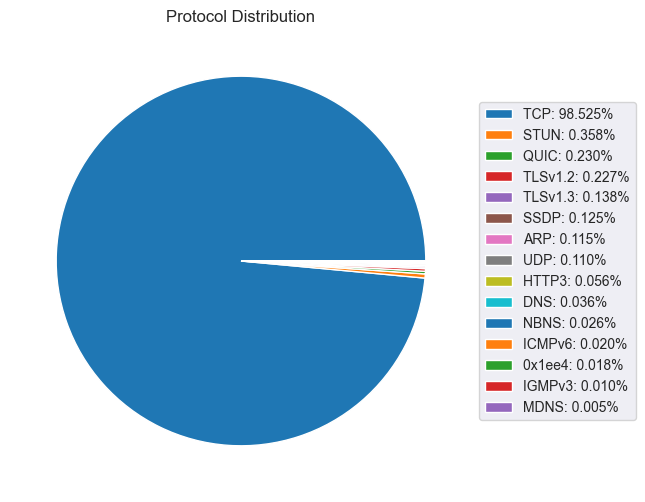

In [64]:
# Calculate protocol counts and their percentages
protocol_counts = video_conference_google_meet['Protocol'].value_counts()
protocol_percentages = protocol_counts / protocol_counts.sum() * 100

# Sort the protocol counts by percentage
sorted_protocols = protocol_percentages.sort_values(ascending=False)

# Create the pie chart
plt.figure(figsize=(10, 6))
ax = sorted_protocols.plot.pie(autopct=None, labels=['']*len(sorted_protocols))

# Add a legend with sorted protocol names and percentages
legend_labels = [f'{protocol}: {percentage:.3f}%' for protocol, percentage in sorted_protocols.items()]
ax.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Protocol Distribution')
plt.ylabel('')
plt.show()

We can see that almost all the packets are using TCP protocol, followed by QUIQ, and a small percentage of packets are using TLS and UDP protocols.<br> We find that the reason that the most packets are TCP instead of UDP is because google meet is browser-based implementation and the browser itself using the TCP protocol.

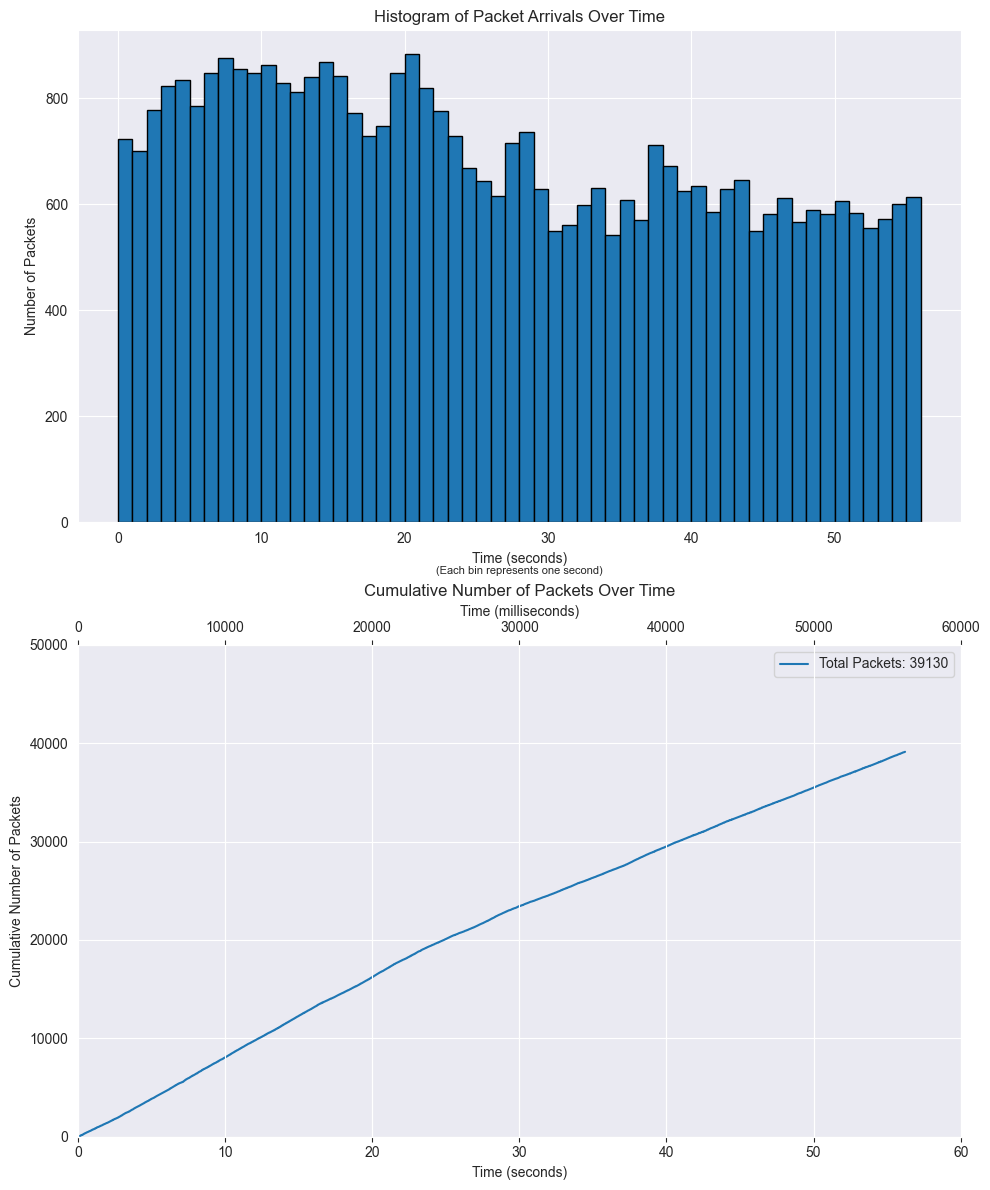

In [65]:
# Ensure 'Time' column is correctly referenced
if 'Time' in video_conference_google_meet.columns:
    # Create a copy of the DataFrame for plotting
    plot_data = video_conference_google_meet.copy()

    # Set the 'Time' column as the index in the copy
    plot_data.set_index('Time', inplace=True)

    # Convert 'Time' index to milliseconds and seconds
    plot_data['Time_ms'] = plot_data.index.total_seconds() * 1000
    plot_data['Time_s'] = plot_data.index.total_seconds()

    # Sort the index
    plot_data.sort_index(inplace=True)

    # Calculate the cumulative count of packets
    plot_data['Cumulative_Count'] = range(1, len(plot_data) + 1)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Plot the histogram of packet arrivals with bins of 1 second
    ax1.hist(plot_data['Time_s'], bins=range(0, int(plot_data['Time_s'].max()) + 1), edgecolor='black')
    ax1.set_title('Histogram of Packet Arrivals Over Time')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Number of Packets')
    ax1.text(0.5, -0.1, '(Each bin represents one second)', ha='center', va='center', transform=ax1.transAxes, fontsize=8)

    # Plot the cumulative count of packets
    ax2.plot(plot_data['Time_s'], plot_data['Cumulative_Count'], label='Cumulative Count')
    ax2.set_title('Cumulative Number of Packets Over Time')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Cumulative Number of Packets')
    ax2.set_xlim(0, 60)
    ax2.set_ylim(0, 50000)
    total_packets = plot_data['Cumulative_Count'].max()
    ax2.legend([f'Total Packets: {total_packets}'])

    # Create a secondary x-axis for milliseconds
    ax2_sec = ax2.twiny()
    ax2_sec.set_xlim(0, 60000)
    ax2_sec.set_xlabel('Time (milliseconds)')

    # Display the plots
    plt.tight_layout()
    plt.show()
else:
    print("The 'Time' column is not found in the DataFrame.")

- We can see that every sec in the histogram that the number of packets arrived in the first 20 seconds is higher than the other seconds, but overall every second we received approximate the same amount of packages. (we assume that in the first 20 seconds the connection is established and the data contains data the is not only video and audio data).
- We can also see that the cumulative number of packets is increasing linearly without sudden increases, which indicates that the packets are arriving at a constant rate.

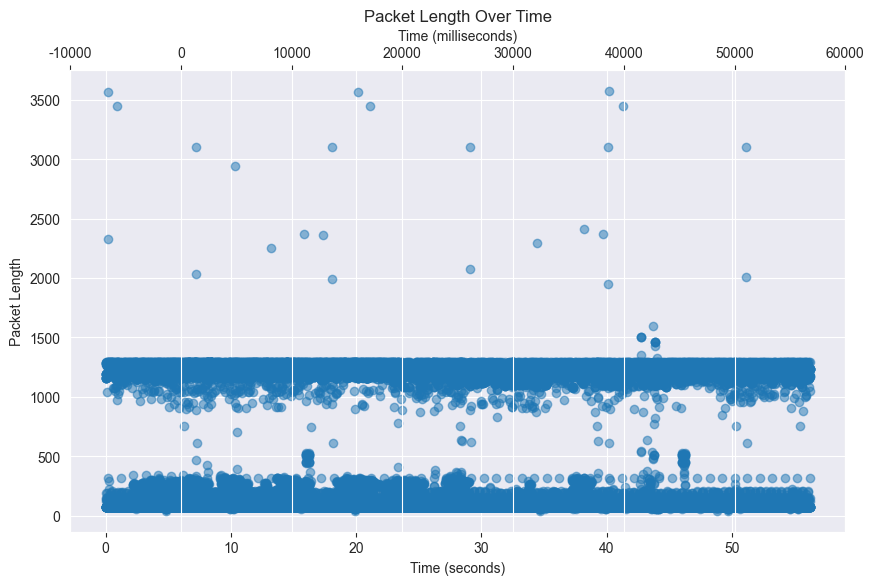

In [66]:
# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(video_conference_google_meet['Time'].dt.total_seconds(), video_conference_google_meet['Length'], alpha=0.5)
plt.title('Packet Length Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Packet Length')

# Create a secondary x-axis for milliseconds
ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel('Time (milliseconds)')
ax2.set_xticks(ax1.get_xticks())
ax2.set_xticklabels([int(x * 1000) for x in ax1.get_xticks()])

plt.show()

- We can see that the packet length is varying over time, with most packets having a length of around 100–500 or 1000-1500 bytes. The packet lengths are not constant, and there are variations in the lengths of the packets received over time.
- Moreover, we can see that there are a lot of packets with a length of 0 bytes, which might be ACK packets or other control packets, and a lot of packets with a length of approximate 1300 bytes, which might be packets full of data, and there are some packets with a length of more than 1500 bytes which might be packets that are not fragmented.

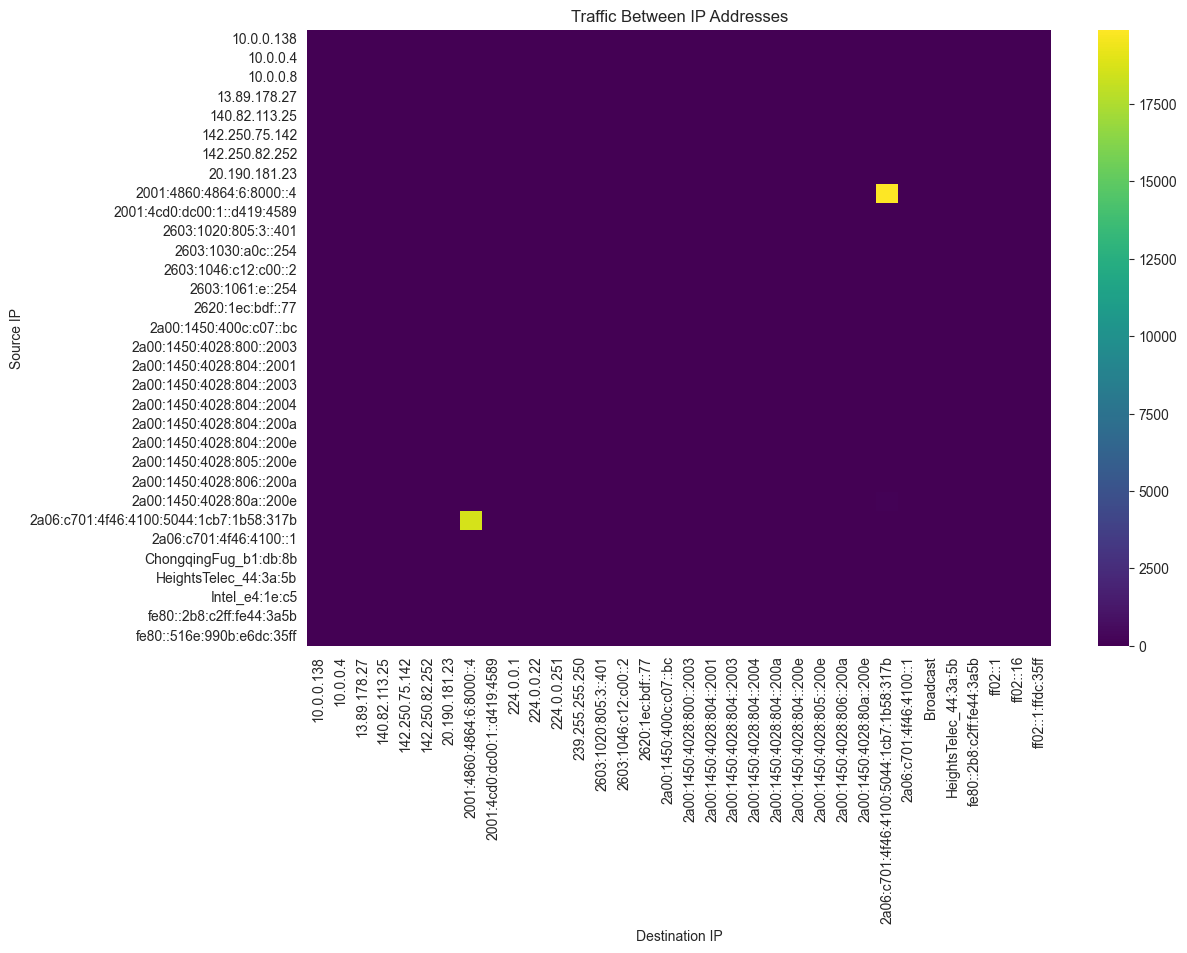

In [67]:
# Heatmap
heatmap_data = pd.crosstab(video_conference_google_meet['Source'], video_conference_google_meet['Destination'])
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis')
plt.title('Traffic Between IP Addresses')
plt.xlabel('Destination IP')
plt.ylabel('Source IP')
plt.show()

We can see that most of the traffic is between the same source and destination IP addresses, which is what we would expect in a video conferencing scenario where the data is exchanged between two parties.

## Video Streaming:

For video streaming, we will analyze the video streaming data from YouTube using Google Chrome browser.<br> While recording I watch one video and then watch another video and stop the recording in the middle of the second video.

In [68]:
from datetime import datetime, timedelta

# Read the CSV file into a DataFrame
video_streaming_youtube = pd.read_csv('video_streaming_youtube.csv')

# Convert the 'Time' column to datetime with the correct format
video_streaming_youtube['Time'] = pd.to_datetime(video_streaming_youtube['Time'], format='%Y/%j %H:%M:%S.%f')

# Calculate the time difference from the start of the recording
start_time = video_streaming_youtube['Time'].iloc[0]
video_streaming_youtube['Time'] = video_streaming_youtube['Time'] - start_time

# Convert the time difference to timedelta and format it
video_streaming_youtube['Time'] = video_streaming_youtube['Time'].apply(lambda x: timedelta(seconds=x.total_seconds()))

# Display the updated DataFrame
video_streaming_youtube.head()

No.                   Time                                   Source  \
0    1        0 days 00:00:00  2a06:c701:4f46:4100:5044:1cb7:1b58:317b   
1    2 0 days 00:00:00.007886     2a06:c700:2002:b:face:b00c:3333:7020   
2    3 0 days 00:00:00.007952  2a06:c701:4f46:4100:5044:1cb7:1b58:317b   
3    4 0 days 00:00:00.009458                 2a00:1450:4028:800::2016   
4    5 0 days 00:00:00.009458                 2a00:1450:4028:800::2016   

                               Destination Protocol  Length  \
0                 2a00:1450:4028:800::2016      UDP     249   
1  2a06:c701:4f46:4100:5044:1cb7:1b58:317b  TLSv1.2     113   
2     2a06:c700:2002:b:face:b00c:3333:7020      TCP      74   
3  2a06:c701:4f46:4100:5044:1cb7:1b58:317b      UDP    1287   
4  2a06:c701:4f46:4100:5044:1cb7:1b58:317b      UDP    1292   

                                              Info  
0                            51741  >  443 Len=187  
1                                 Application Data  
2  52967  >  443 [ACK] Seq=1 Ack=40 Win=1021 Len=0  
3                           443  >  51741 Len=1225  
4                           443  >  51741 Len=1230

In [69]:
video_streaming_youtube.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24723 entries, 0 to 24722
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   No.          24723 non-null  int64          
 1   Time         24723 non-null  timedelta64[ns]
 2   Source       24723 non-null  object         
 3   Destination  24723 non-null  object         
 4   Protocol     24723 non-null  object         
 5   Length       24723 non-null  int64          
 6   Info         24723 non-null  object         
dtypes: int64(2), object(4), timedelta64[ns](1)
memory usage: 1.3+ MB


In [70]:
video_streaming_youtube.describe()

No.                       Time        Length
count  24723.000000                      24723  24723.000000
mean   12362.000000  0 days 00:02:03.694687491   1037.624479
std     7137.059689  0 days 00:01:24.018235577    494.855177
min        1.000000            0 days 00:00:00     42.000000
25%     6181.500000  0 days 00:00:35.853801500   1292.000000
50%    12362.000000     0 days 00:02:31.769176   1292.000000
75%    18542.500000     0 days 00:03:20.398799   1292.000000
max    24723.000000     0 days 00:04:06.716890  13468.000000

We can see that almost all the segments length is 1292 bytes.

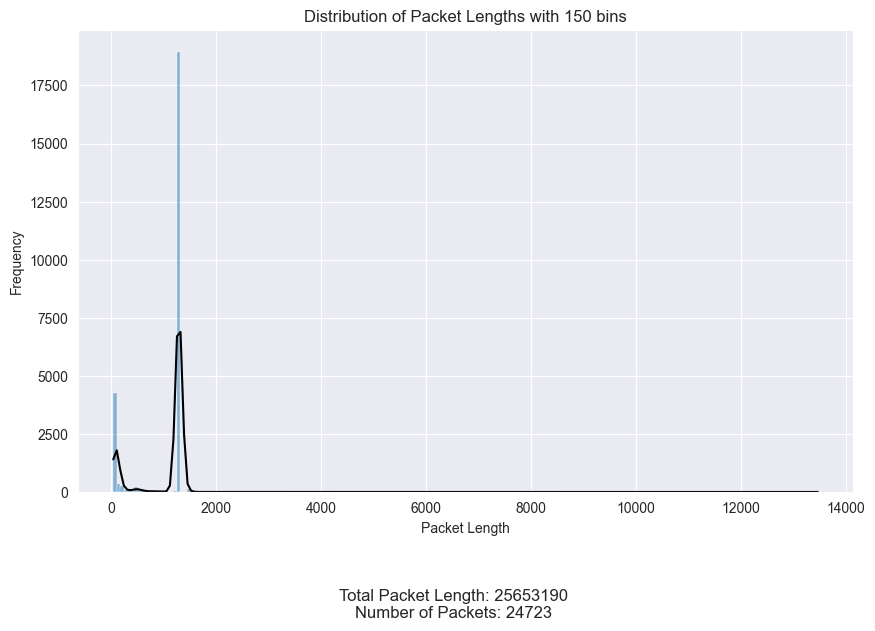

In [71]:
# Replace infinite values with NaN
video_streaming_youtube.replace([float('inf'), -float('inf')], float('nan'), inplace=True)

# Calculate the total sum of packet lengths and the number of packets
total_packet_length = video_streaming_youtube['Length'].sum()
number_of_packets = video_streaming_youtube['Length'].count()

# Create the histogram with KDE
plt.figure(figsize=(10, 6))
ax = sns.histplot(video_streaming_youtube['Length'], bins=200, kde=True)

# Set the color of the KDE line to black
for line in ax.lines:
    line.set_color('black')

plt.title('Distribution of Packet Lengths with 150 bins')
plt.xlabel('Packet Length')
plt.ylabel('Frequency')

# Add text below the plot
plt.figtext(0.5, -0.1, f'Total Packet Length: {int(total_packet_length)}\nNumber of Packets: {number_of_packets}',
            ha='center', fontsize=12)

plt.show()

We already saw that almost all the data has length of 1292 so we expected to see it in the histogram, and we see that more than 17500 packets from total of 24723 packets have approximate length of 1292 bytes.

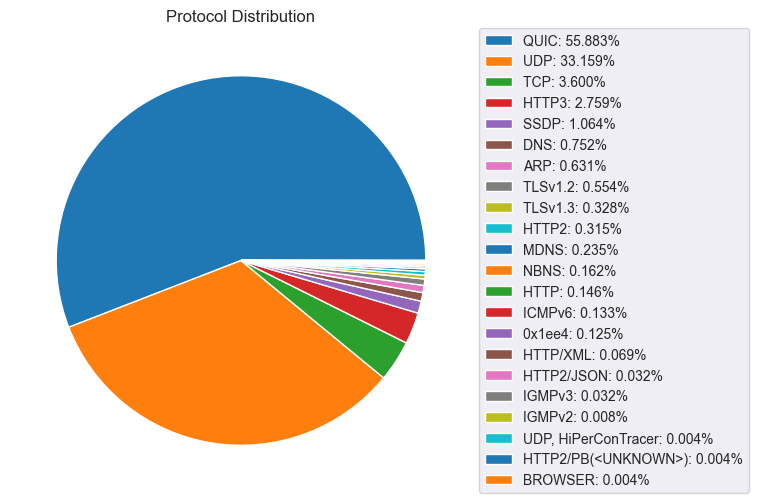

In [72]:
# Calculate protocol counts and their percentages
protocol_counts = video_streaming_youtube['Protocol'].value_counts()
protocol_percentages = protocol_counts / protocol_counts.sum() * 100

# Sort the protocol counts by percentage
sorted_protocols = protocol_percentages.sort_values(ascending=False)

# Create the pie chart
plt.figure(figsize=(10, 6))
ax = sorted_protocols.plot.pie(autopct=None, labels=['']*len(sorted_protocols))

# Add a legend with sorted protocol names and percentages
legend_labels = [f'{protocol}: {percentage:.3f}%' for protocol, percentage in sorted_protocols.items()]
ax.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Protocol Distribution')
plt.ylabel('')
plt.show()

We see that YouTube use mostly in QUIQ and UDP, and a little TCP. QUIQ is protocol to send reliable data and solve some problems of TCP. We should think that YouTube that send video streaming will use UDP f most of its data, I found article that explain why YouTUbe uses TCP in its transport layer [in this link](https://www.geeksforgeeks.org/why-is-youtube-using-tcp-but-not-udp/), and because the article is from 2021 I assume that YouTube now uses QUIQ instead of TCP. <br> YouTube also uses UDP because they use `RTSP` protocol and this protocol use UDP and TCP, that's why we see UDP and QUIQ in large percentage.

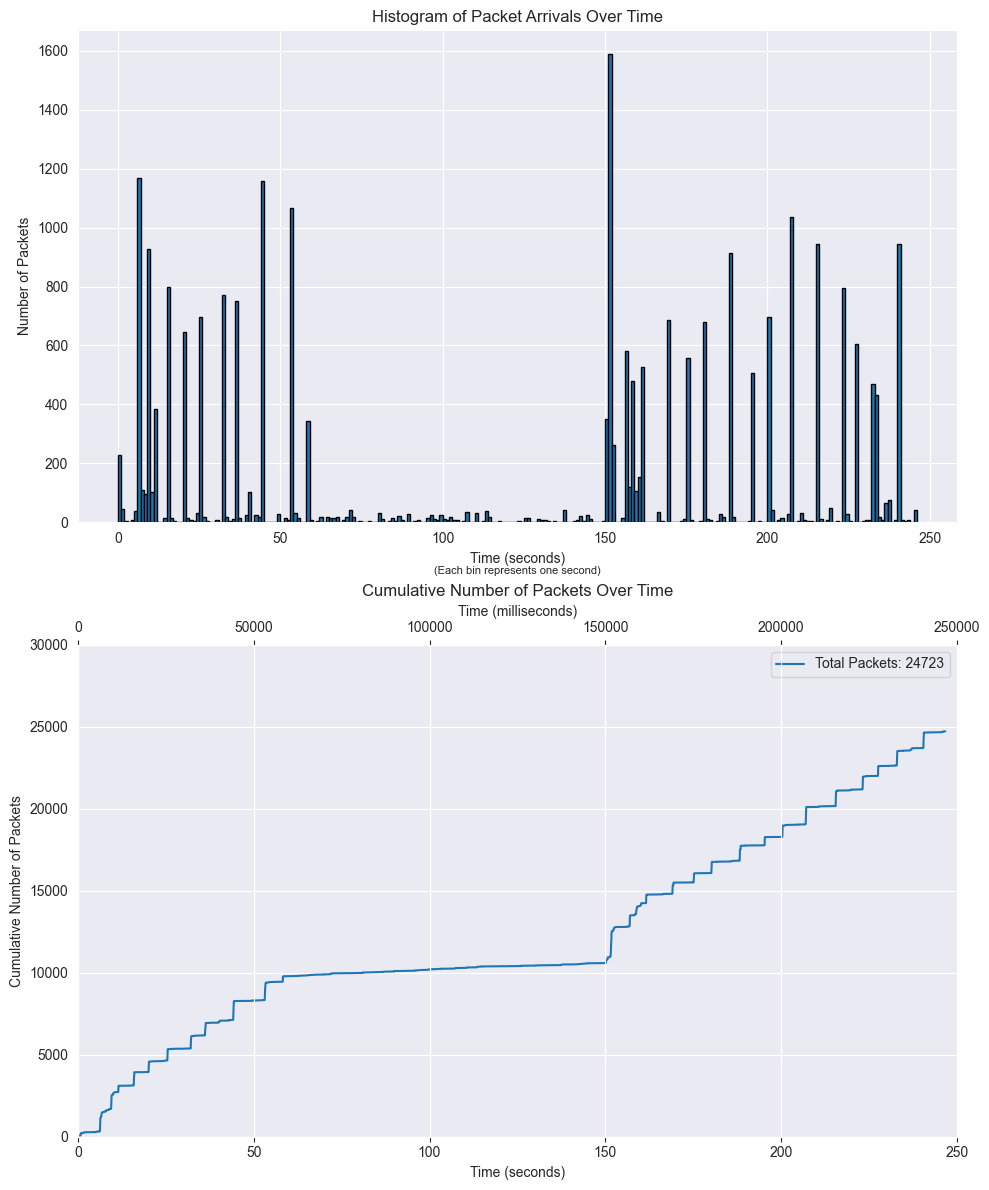

In [73]:
# Ensure 'Time' column is correctly referenced
if 'Time' in video_streaming_youtube.columns:
    # Create a copy of the DataFrame for plotting
    plot_data = video_streaming_youtube.copy()

    # Set the 'Time' column as the index in the copy
    plot_data.set_index('Time', inplace=True)

    # Convert 'Time' index to milliseconds and seconds
    plot_data['Time_ms'] = plot_data.index.total_seconds() * 1000
    plot_data['Time_s'] = plot_data.index.total_seconds()

    # Sort the index
    plot_data.sort_index(inplace=True)

    # Calculate the cumulative count of packets
    plot_data['Cumulative_Count'] = range(1, len(plot_data) + 1)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Plot the histogram of packet arrivals with bins of 1 second
    ax1.hist(plot_data['Time_s'], bins=range(0, int(plot_data['Time_s'].max()) + 1), edgecolor='black')
    ax1.set_title('Histogram of Packet Arrivals Over Time')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Number of Packets')
    ax1.text(0.5, -0.1, '(Each bin represents one second)', ha='center', va='center', transform=ax1.transAxes, fontsize=8)

    # Plot the cumulative count of packets
    ax2.plot(plot_data['Time_s'], plot_data['Cumulative_Count'], label='Cumulative Count')
    ax2.set_title('Cumulative Number of Packets Over Time')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Cumulative Number of Packets')
    ax2.set_xlim(0, 250)
    ax2.set_ylim(0, 30000)
    total_packets = plot_data['Cumulative_Count'].max()
    ax2.legend([f'Total Packets: {total_packets}'])

    # Create a secondary x-axis for milliseconds
    ax2_sec = ax2.twiny()
    ax2_sec.set_xlim(0, 250000)
    ax2_sec.set_xlabel('Time (milliseconds)')

    # Display the plots
    plt.tight_layout()
    plt.show()
else:
    print("The 'Time' column is not found in the DataFrame.")

We can see the regular pulses of data that we know from class (the steps in the second graph) and we see a long pause in the sending data, in this time the first video will finish to send his data, and we see jump when I load the new video and return to regular transfer data as we know it.

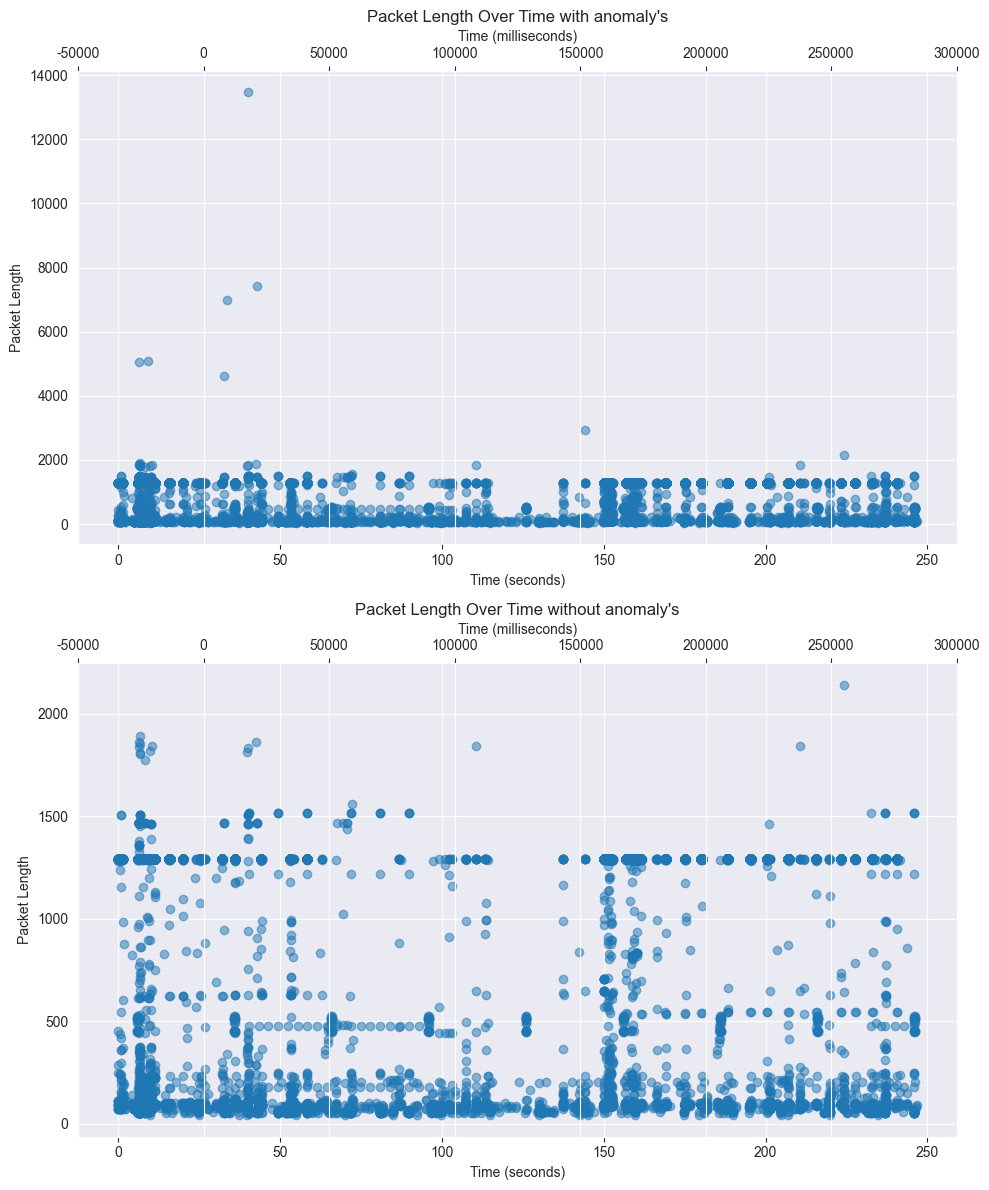

In [74]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Scatter Plot for all data
ax1.scatter(video_streaming_youtube['Time'].dt.total_seconds(), video_streaming_youtube['Length'], alpha=0.5)
ax1.set_title("Packet Length Over Time with anomaly's")
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Packet Length')

# Create a secondary x-axis for milliseconds
ax1_sec = ax1.twiny()
ax1_sec.set_xlim(ax1.get_xlim())
ax1_sec.set_xlabel('Time (milliseconds)')
ax1_sec.set_xticks(ax1.get_xticks())
ax1_sec.set_xticklabels([int(x * 1000) for x in ax1.get_xticks()])

# Filter data to ignore cases where packet length is larger than 2500
filtered_data = video_streaming_youtube[video_streaming_youtube['Length'] <= 2500]

# Scatter Plot for filtered data
ax2.scatter(filtered_data['Time'].dt.total_seconds(), filtered_data['Length'], alpha=0.5)
ax2.set_title("Packet Length Over Time without anomaly's")
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Packet Length')

# Create a secondary x-axis for milliseconds
ax2_sec = ax2.twiny()
ax2_sec.set_xlim(ax2.get_xlim())
ax2_sec.set_xlabel('Time (milliseconds)')
ax2_sec.set_xticks(ax2.get_xticks())
ax2_sec.set_xticklabels([int(x * 1000) for x in ax2.get_xticks()])

plt.tight_layout()
plt.show()

We can see that without anomaly's the length of the packets varray from 0 to 1292 as we mentioned earlier, the length 1292 is probably received a lot of same length packets at the same time and the dots is on each other because we know that most of the packets is with length of 1292 bytes.

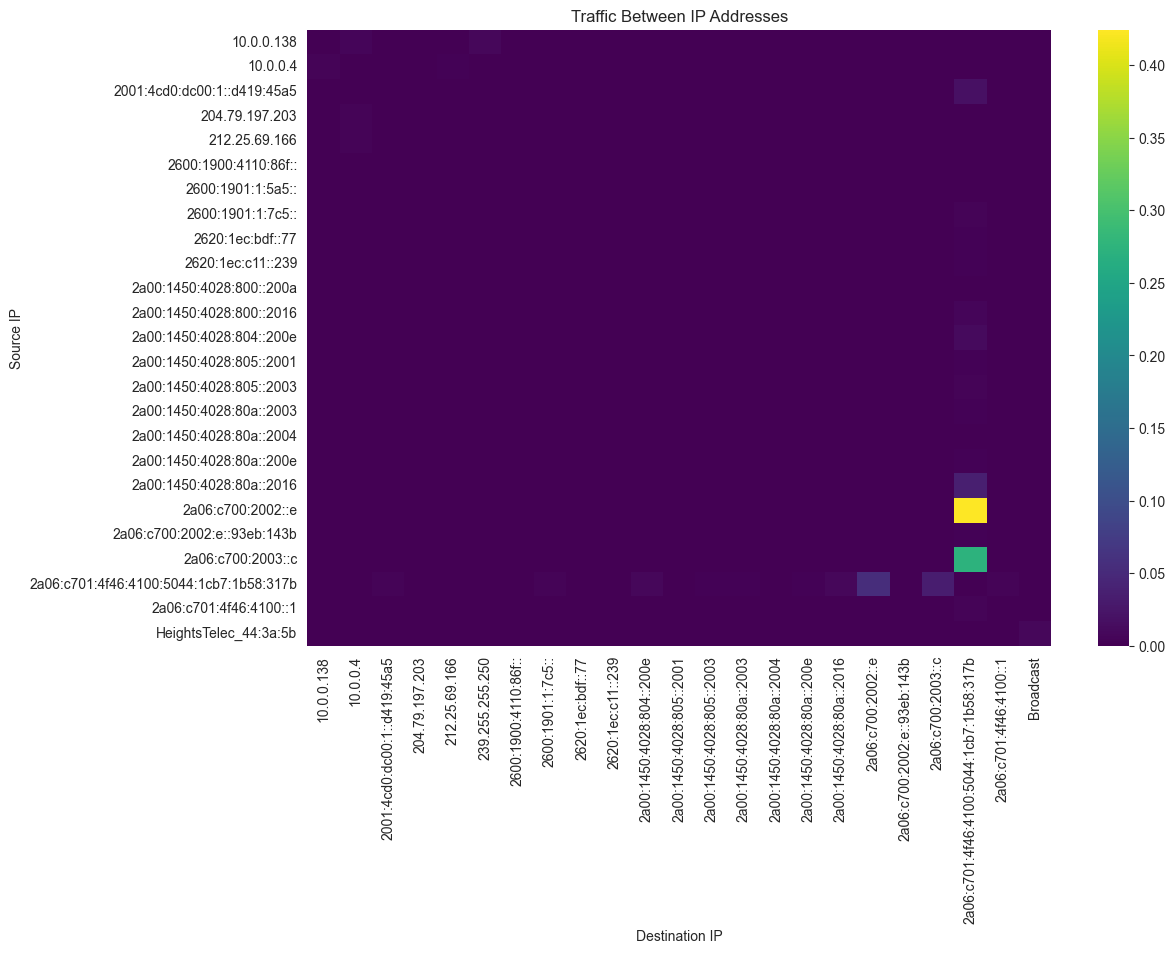

In [75]:
# Calculate the total traffic
total_traffic = video_streaming_youtube.shape[0]

# Create the crosstab
heatmap_data = pd.crosstab(video_streaming_youtube['Source'], video_streaming_youtube['Destination'])

# Filter out addresses with traffic less than 0.01% of the total
threshold = total_traffic * 0.001
filtered_heatmap_data = heatmap_data[heatmap_data > threshold].dropna(axis=0, how='all').dropna(axis=1, how='all')

# Calculate the ratio for each cell
ratio_heatmap_data = filtered_heatmap_data / total_traffic

# Fill NaN values with their real ratio
filled_heatmap_data = ratio_heatmap_data.fillna(0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filled_heatmap_data, cmap='viridis')
plt.title('Traffic Between IP Addresses')
plt.xlabel('Destination IP')
plt.ylabel('Source IP')
plt.show()

We can see that there is some ip source have multiple sources but there is only one major destination (we assume that the other destination was packet that sent from my computer to other destination) and we see that in the other destination this ip is the source.

## Audio Streaming

In this section we record spotify application in computer, we ran a podcast in the application and receive packets.

In [76]:
from datetime import datetime, timedelta

# Read the CSV file into a DataFrame
audio_streaming_spotify = pd.read_csv('audio_streaming_spotify.csv')

# Convert the 'Time' column to datetime with the correct format
audio_streaming_spotify['Time'] = pd.to_datetime(audio_streaming_spotify['Time'], format='%Y/%j %H:%M:%S.%f')

# Calculate the time difference from the start of the recording
start_time = audio_streaming_spotify['Time'].iloc[0]
audio_streaming_spotify['Time'] = audio_streaming_spotify['Time'] - start_time

# Convert the time difference to timedelta and format it
audio_streaming_spotify['Time'] = audio_streaming_spotify['Time'].apply(lambda x: timedelta(seconds=x.total_seconds()))

# Display the updated DataFrame
audio_streaming_spotify.head()

No.                   Time                                   Source  \
0    1        0 days 00:00:00  2a06:c701:4f46:4100:5044:1cb7:1b58:317b   
1    2 0 days 00:00:00.000212  2a06:c701:4f46:4100:5044:1cb7:1b58:317b   
2    3 0 days 00:00:00.016050                        2600:1901:1:5a5::   
3    4 0 days 00:00:00.017334                        2600:1901:1:5a5::   
4    5 0 days 00:00:00.018186                        2600:1901:1:5a5::   

                               Destination Protocol  Length  \
0                        2600:1901:1:5a5::  TLSv1.3    1809   
1                        2600:1901:1:5a5::     QUIC    1292   
2  2a06:c701:4f46:4100:5044:1cb7:1b58:317b      TCP      74   
3  2a06:c701:4f46:4100:5044:1cb7:1b58:317b      TCP      74   
4  2a06:c701:4f46:4100:5044:1cb7:1b58:317b     QUIC    1292   

                                                Info  
0       Client Hello (SNI=gew1-spclient.spotify.com)  
1                     Initial, DCID=fdfa0b6eebec076a  
2  443  >  52889 [ACK] Seq=1 Ack=1433 Win=1047 Len=0  
3  443  >  52889 [ACK] Seq=1 Ack=1736 Win=1046 Len=0  
4                     Initial, SCID=fdfa0b6eebec076a

In [77]:
audio_streaming_spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10472 entries, 0 to 10471
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   No.          10472 non-null  int64          
 1   Time         10472 non-null  timedelta64[ns]
 2   Source       10472 non-null  object         
 3   Destination  10472 non-null  object         
 4   Protocol     10472 non-null  object         
 5   Length       10472 non-null  int64          
 6   Info         10472 non-null  object         
dtypes: int64(2), object(4), timedelta64[ns](1)
memory usage: 572.8+ KB


In [78]:
audio_streaming_spotify.describe()

No.                       Time        Length
count  10472.000000                      10472  10472.000000
mean    5236.500000  0 days 00:00:49.896602028    935.191940
std     3023.150344  0 days 00:00:12.349626819    671.555268
min        1.000000            0 days 00:00:00     42.000000
25%     2618.750000  0 days 00:00:50.468945250     66.000000
50%     5236.500000     0 days 00:00:52.752644   1465.000000
75%     7854.250000     0 days 00:00:54.864761   1465.000000
max    10472.000000     0 days 00:01:14.049202   6400.000000

We can now see that a lot of packets are with length of 1465 bytes.

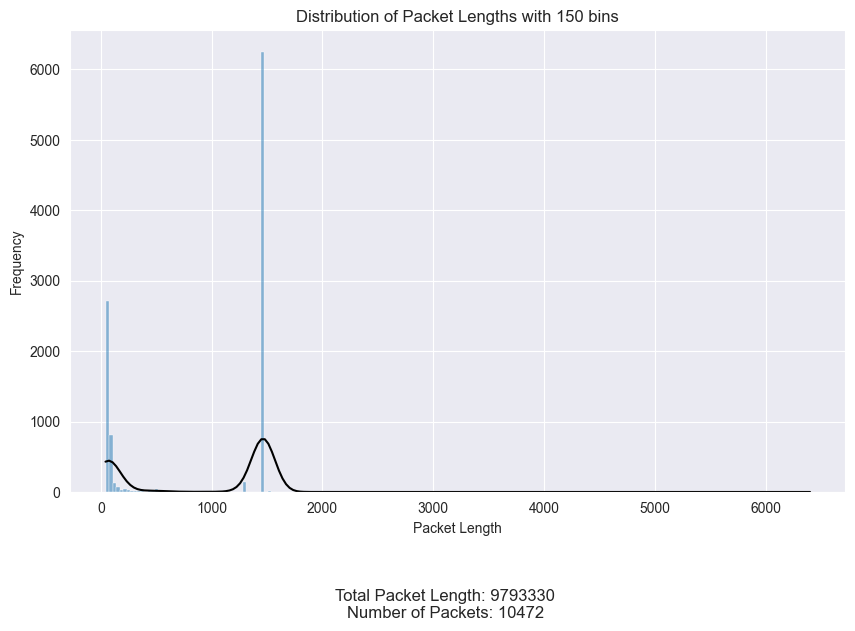

In [79]:
# Replace infinite values with NaN
audio_streaming_spotify.replace([float('inf'), -float('inf')], float('nan'), inplace=True)

# Calculate the total sum of packet lengths and the number of packets
total_packet_length = audio_streaming_spotify['Length'].sum()
number_of_packets = audio_streaming_spotify['Length'].count()

# Create the histogram with KDE
plt.figure(figsize=(10, 6))
ax = sns.histplot(audio_streaming_spotify['Length'], bins=200, kde=True)

# Set the color of the KDE line to black
for line in ax.lines:
    line.set_color('black')

plt.title('Distribution of Packet Lengths with 150 bins')
plt.xlabel('Packet Length')
plt.ylabel('Frequency')

# Add text below the plot
plt.figtext(0.5, -0.1, f'Total Packet Length: {int(total_packet_length)}\nNumber of Packets: {number_of_packets}',
            ha='center', fontsize=12)

plt.show()

We can see there is more than 6000 packets with length of 1465 bytes from total of 10472, more than half.

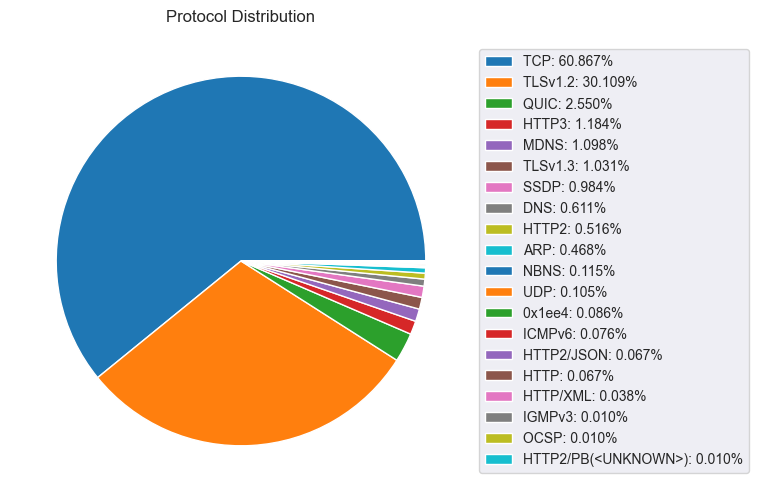

In [80]:
# Calculate protocol counts and their percentages
protocol_counts = audio_streaming_spotify['Protocol'].value_counts()
protocol_percentages = protocol_counts / protocol_counts.sum() * 100

# Sort the protocol counts by percentage
sorted_protocols = protocol_percentages.sort_values(ascending=False)

# Create the pie chart
plt.figure(figsize=(10, 6))
ax = sorted_protocols.plot.pie(autopct=None, labels=['']*len(sorted_protocols))

# Add a legend with sorted protocol names and percentages
legend_labels = [f'{protocol}: {percentage:.3f}%' for protocol, percentage in sorted_protocols.items()]
ax.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Protocol Distribution')
plt.ylabel('')
plt.show()

We see that audio relay on reliable transport (like TCP or QUIQ) instead of unreliable transport (like UDP)

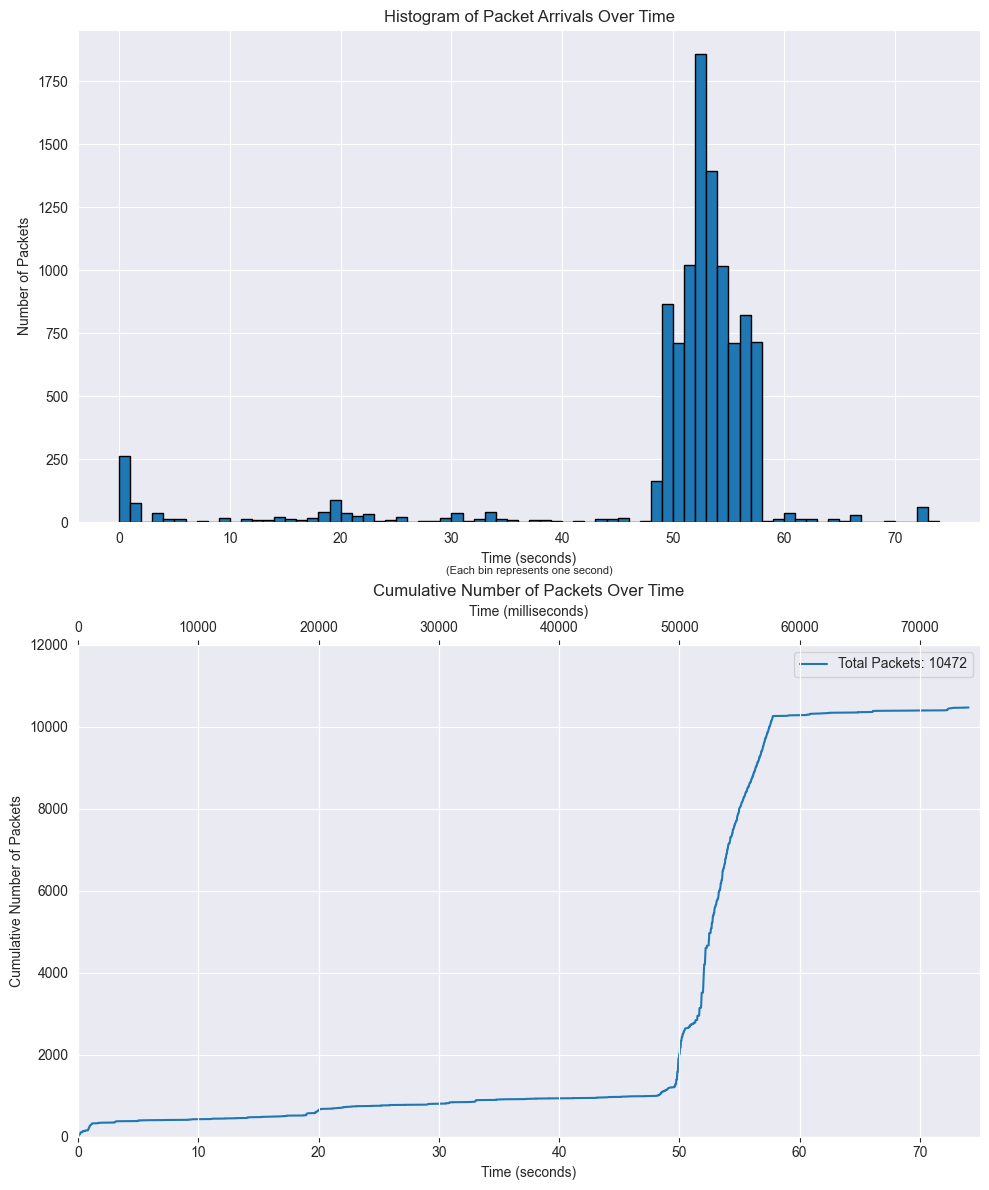

In [81]:
# Ensure 'Time' column is correctly referenced
if 'Time' in audio_streaming_spotify.columns:
    # Create a copy of the DataFrame for plotting
    plot_data = audio_streaming_spotify.copy()

    # Set the 'Time' column as the index in the copy
    plot_data.set_index('Time', inplace=True)

    # Convert 'Time' index to milliseconds and seconds
    plot_data['Time_ms'] = plot_data.index.total_seconds() * 1000
    plot_data['Time_s'] = plot_data.index.total_seconds()

    # Sort the index
    plot_data.sort_index(inplace=True)

    # Calculate the cumulative count of packets
    plot_data['Cumulative_Count'] = range(1, len(plot_data) + 1)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Plot the histogram of packet arrivals with bins of 1 second
    ax1.hist(plot_data['Time_s'], bins=range(0, int(plot_data['Time_s'].max()) + 1), edgecolor='black')
    ax1.set_title('Histogram of Packet Arrivals Over Time')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Number of Packets')
    ax1.text(0.5, -0.1, '(Each bin represents one second)', ha='center', va='center', transform=ax1.transAxes, fontsize=8)

    # Plot the cumulative count of packets
    ax2.plot(plot_data['Time_s'], plot_data['Cumulative_Count'], label='Cumulative Count')
    ax2.set_title('Cumulative Number of Packets Over Time')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Cumulative Number of Packets')
    ax2.set_xlim(0, 75)
    ax2.set_ylim(0, 12000)
    total_packets = plot_data['Cumulative_Count'].max()
    ax2.legend([f'Total Packets: {total_packets}'])

    # Create a secondary x-axis for milliseconds
    ax2_sec = ax2.twiny()
    ax2_sec.set_xlim(0, 75000)
    ax2_sec.set_xlabel('Time (milliseconds)')

    # Display the plots
    plt.tight_layout()
    plt.show()
else:
    print("The 'Time' column is not found in the DataFrame.")

We can see that most of the packet received in approximate 10 seconds (almost 10,000 packets) that contains data, we notice most of the transport was over TCP so we assume there is alot of ACK's there as well.

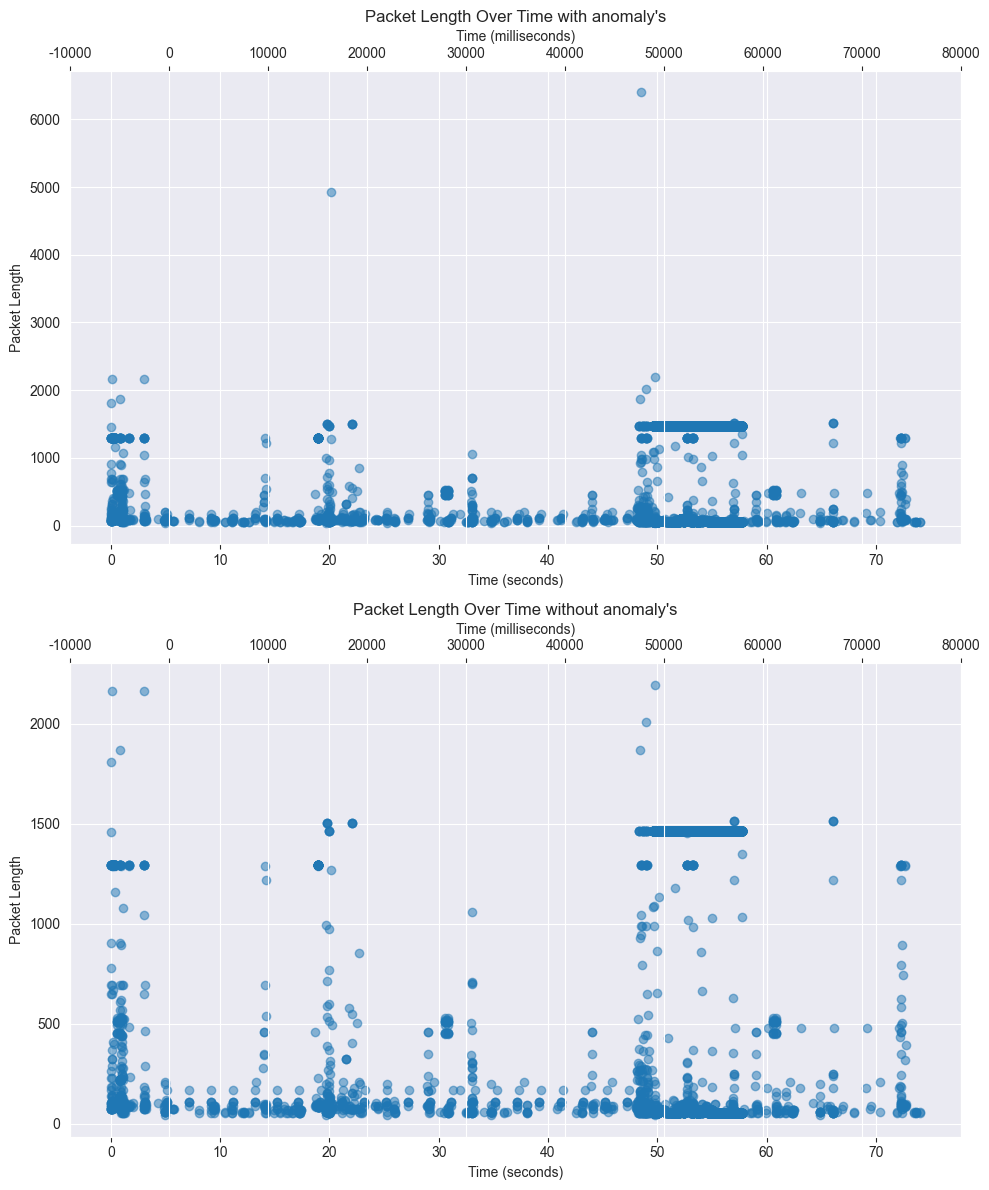

In [82]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Scatter Plot for all data
ax1.scatter(audio_streaming_spotify['Time'].dt.total_seconds(), audio_streaming_spotify['Length'], alpha=0.5)
ax1.set_title("Packet Length Over Time with anomaly's")
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Packet Length')

# Create a secondary x-axis for milliseconds
ax1_sec = ax1.twiny()
ax1_sec.set_xlim(ax1.get_xlim())
ax1_sec.set_xlabel('Time (milliseconds)')
ax1_sec.set_xticks(ax1.get_xticks())
ax1_sec.set_xticklabels([int(x * 1000) for x in ax1.get_xticks()])

# Filter data to ignore cases where packet length is larger than 2500
filtered_data = audio_streaming_spotify[audio_streaming_spotify['Length'] <= 2500]

# Scatter Plot for filtered data
ax2.scatter(filtered_data['Time'].dt.total_seconds(), filtered_data['Length'], alpha=0.5)
ax2.set_title("Packet Length Over Time without anomaly's")
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Packet Length')

# Create a secondary x-axis for milliseconds
ax2_sec = ax2.twiny()
ax2_sec.set_xlim(ax2.get_xlim())
ax2_sec.set_xlabel('Time (milliseconds)')
ax2_sec.set_xticks(ax2.get_xticks())
ax2_sec.set_xticklabels([int(x * 1000) for x in ax2.get_xticks()])

plt.tight_layout()
plt.show()

As we have seen earlier, most of the packets contain 1492 bytes, we can also see that most of them if not all are within the tes seconds that most of the data was received.

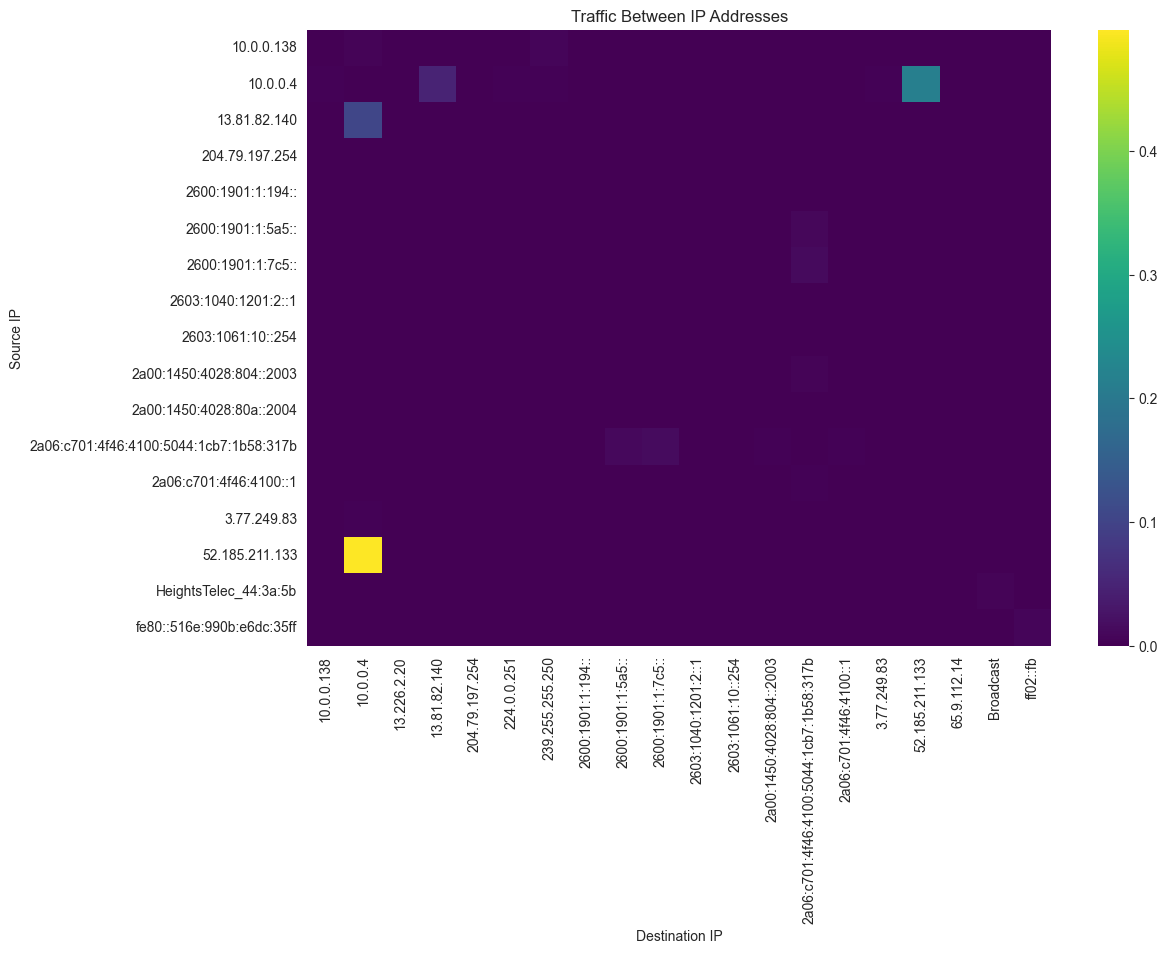

In [83]:
# Calculate the total traffic
total_traffic = audio_streaming_spotify.shape[0]

# Create the crosstab
heatmap_data = pd.crosstab(audio_streaming_spotify['Source'], audio_streaming_spotify['Destination'])

# Filter out addresses with traffic less than 0.01% of the total
threshold = total_traffic * 0.001
filtered_heatmap_data = heatmap_data[heatmap_data > threshold].dropna(axis=0, how='all').dropna(axis=1, how='all')

# Calculate the ratio for each cell
ratio_heatmap_data = filtered_heatmap_data / total_traffic

# Fill NaN values with their real ratio
filled_heatmap_data = ratio_heatmap_data.fillna(0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filled_heatmap_data, cmap='viridis')
plt.title('Traffic Between IP Addresses')
plt.xlabel('Destination IP')
plt.ylabel('Source IP')
plt.show()

We can see also that almost all the traffic are between two IP address's as we assume because one side transmit data to the other and because its TCP the other return ACK's

### Web browser Chrome:

In [84]:
from datetime import datetime, timedelta

# Read the CSV file into a DataFrame
web_surfing_chrome = pd.read_csv('web_surfing_1_chrome.csv')

# Convert the 'Time' column to datetime with the correct format
web_surfing_chrome['Time'] = pd.to_datetime(web_surfing_chrome['Time'], format='%Y/%j %H:%M:%S.%f')

# Calculate the time difference from the start of the recording
start_time = web_surfing_chrome['Time'].iloc[0]
web_surfing_chrome['Time'] = web_surfing_chrome['Time'] - start_time

# Convert the time difference to timedelta and format it
web_surfing_chrome['Time'] = web_surfing_chrome['Time'].apply(lambda x: timedelta(seconds=x.total_seconds()))

# Display the updated DataFrame
web_surfing_chrome.head()

No.                   Time                                   Source  \
0    1        0 days 00:00:00                    HeightsTelec_44:3a:5b   
1    2 0 days 00:00:00.689390  2a06:c701:4f46:4100:5044:1cb7:1b58:317b   
2    3 0 days 00:00:00.689392  2a06:c701:4f46:4100:5044:1cb7:1b58:317b   
3    4 0 days 00:00:00.689810  2a06:c701:4f46:4100:5044:1cb7:1b58:317b   
4    5 0 days 00:00:00.690118  2a06:c701:4f46:4100:5044:1cb7:1b58:317b   

              Destination Protocol  Length  \
0               Broadcast   0x1ee4     206   
1  2a06:c701:4f46:4100::1      DNS      90   
2  2a06:c701:4f46:4100::1      DNS     103   
3  2a06:c701:4f46:4100::1      DNS     103   
4  2a06:c701:4f46:4100::1      DNS      90   

                                                Info  
0                                        Ethernet II  
1                 Standard query 0xd010 A github.com  
2    Standard query 0xa6ab A safebrowsing.google.com  
3  Standard query 0xa536 AAAA safebrowsing.google...  
4              Standard query 0x16be AAAA github.com

In [85]:
web_surfing_chrome.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6994 entries, 0 to 6993
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   No.          6994 non-null   int64          
 1   Time         6994 non-null   timedelta64[ns]
 2   Source       6994 non-null   object         
 3   Destination  6994 non-null   object         
 4   Protocol     6994 non-null   object         
 5   Length       6994 non-null   int64          
 6   Info         6994 non-null   object         
dtypes: int64(2), object(4), timedelta64[ns](1)
memory usage: 382.6+ KB


In [86]:
web_surfing_chrome.describe()

No.                       Time        Length
count  6994.000000                       6994   6994.000000
mean   3497.500000  0 days 00:00:23.138665099    656.807120
std    2019.138224  0 days 00:00:10.371630297   1104.918279
min       1.000000            0 days 00:00:00     42.000000
25%    1749.250000     0 days 00:00:16.714548     86.000000
50%    3497.500000  0 days 00:00:21.460082500    139.000000
75%    5245.750000     0 days 00:00:31.954198   1292.000000
max    6994.000000     0 days 00:00:39.697814  16480.000000

We see in this table that we can't conclude anything because the sdt is more than the mean

In [87]:
result = web_surfing_chrome.groupby('Length').size().sort_values(ascending=False)

result

Length
74      1022
1292     908
1294     683
54       227
93       195
        ... 
731        1
723        1
722        1
721        1
650        1
Length: 830, dtype: int64

we can see that most of the data has small bytes length and there is some with large bytes length around 1292-1465

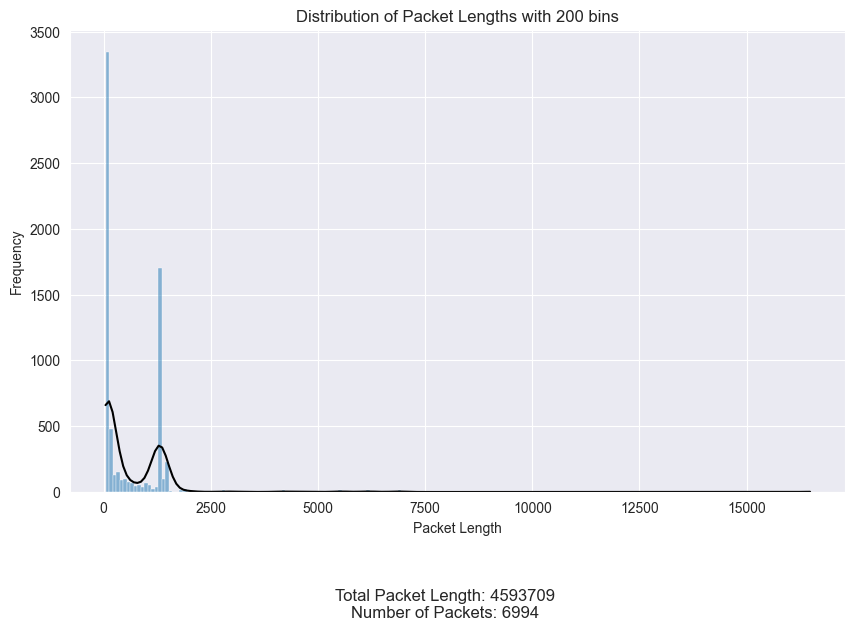

In [88]:
# Replace infinite values with NaN
web_surfing_chrome.replace([float('inf'), -float('inf')], float('nan'), inplace=True)

# Calculate the total sum of packet lengths and the number of packets
total_packet_length = web_surfing_chrome['Length'].sum()
number_of_packets = web_surfing_chrome['Length'].count()

# Create the histogram with KDE
plt.figure(figsize=(10, 6))
ax = sns.histplot(web_surfing_chrome['Length'], bins=200, kde=True)

# Set the color of the KDE line to black
for line in ax.lines:
    line.set_color('black')

plt.title('Distribution of Packet Lengths with 200 bins')
plt.xlabel('Packet Length')
plt.ylabel('Frequency')

# Add text below the plot
plt.figtext(0.5, -0.1, f'Total Packet Length: {int(total_packet_length)}\nNumber of Packets: {number_of_packets}',
            ha='center', fontsize=12)

plt.show()

We can see that the data length is diverse we can see two 'bumps' one is around 0-100 with exception around 1292/1294 and around 1465

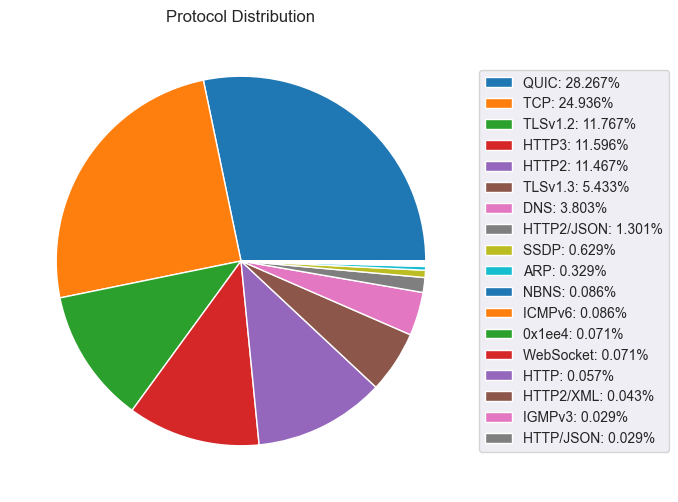

In [89]:
# Calculate protocol counts and their percentages
protocol_counts = web_surfing_chrome['Protocol'].value_counts()
protocol_percentages = protocol_counts / protocol_counts.sum() * 100

# Sort the protocol counts by percentage
sorted_protocols = protocol_percentages.sort_values(ascending=False)

# Create the pie chart
plt.figure(figsize=(10, 6))
ax = sorted_protocols.plot.pie(autopct=None, labels=['']*len(sorted_protocols))

# Add a legend with sorted protocol names and percentages
legend_labels = [f'{protocol}: {percentage:.3f}%' for protocol, percentage in sorted_protocols.items()]
ax.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Protocol Distribution')
plt.ylabel('')
plt.show()

Because we record web surfing we assume that the data is using reliable transfer as we saw in class, and we see in the graph that most of the data protocols are QUIQ and TCP and because HTTP use TLS to encryption we see  more from TLS, we also see a lot of use in HTTP protocols (because its web surfing we assume to see this large amount of use in these protocols)

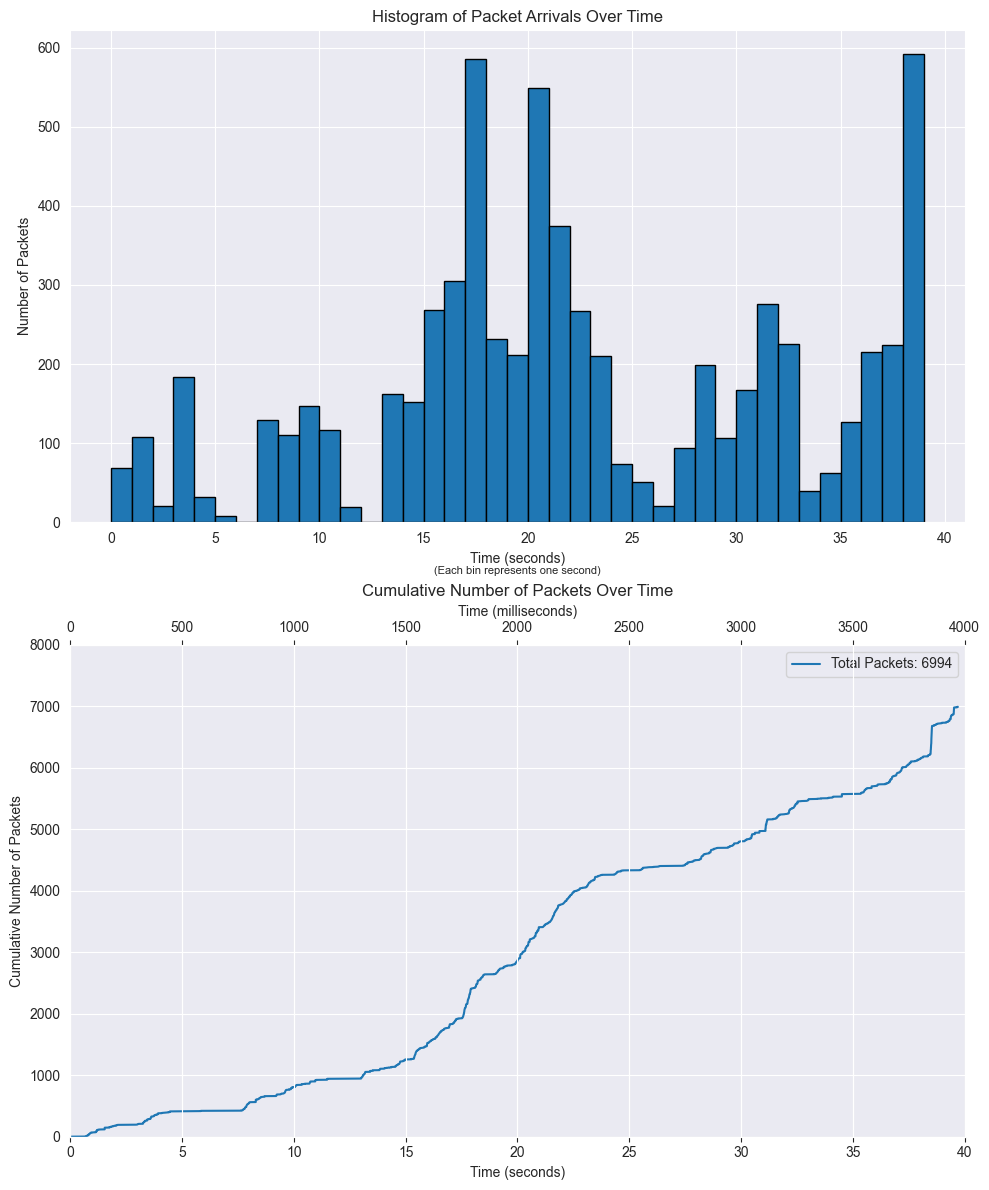

In [90]:
# Ensure 'Time' column is correctly referenced
if 'Time' in web_surfing_chrome.columns:
    # Create a copy of the DataFrame for plotting
    plot_data = web_surfing_chrome.copy()

    # Set the 'Time' column as the index in the copy
    plot_data.set_index('Time', inplace=True)

    # Convert 'Time' index to milliseconds and seconds
    plot_data['Time_ms'] = plot_data.index.total_seconds() * 1000
    plot_data['Time_s'] = plot_data.index.total_seconds()

    # Sort the index
    plot_data.sort_index(inplace=True)

    # Calculate the cumulative count of packets
    plot_data['Cumulative_Count'] = range(1, len(plot_data) + 1)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Plot the histogram of packet arrivals with bins of 1 second
    ax1.hist(plot_data['Time_s'], bins=range(0, int(plot_data['Time_s'].max()) + 1), edgecolor='black')
    ax1.set_title('Histogram of Packet Arrivals Over Time')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Number of Packets')
    ax1.text(0.5, -0.1, '(Each bin represents one second)', ha='center', va='center', transform=ax1.transAxes, fontsize=8)

    # Plot the cumulative count of packets
    ax2.plot(plot_data['Time_s'], plot_data['Cumulative_Count'], label='Cumulative Count')
    ax2.set_title('Cumulative Number of Packets Over Time')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Cumulative Number of Packets')
    ax2.set_xlim(0, 40)
    ax2.set_ylim(0, 8000)
    total_packets = plot_data['Cumulative_Count'].max()
    ax2.legend([f'Total Packets: {total_packets}'])

    # Create a secondary x-axis for milliseconds
    ax2_sec = ax2.twiny()
    ax2_sec.set_xlim(0, 4000)
    ax2_sec.set_xlabel('Time (milliseconds)')

    # Display the plots
    plt.tight_layout()
    plt.show()
else:
    print("The 'Time' column is not found in the DataFrame.")

We see in these graphs a similar to linear growth of the packets, that because we don't have specific pattern how the data should receive over time

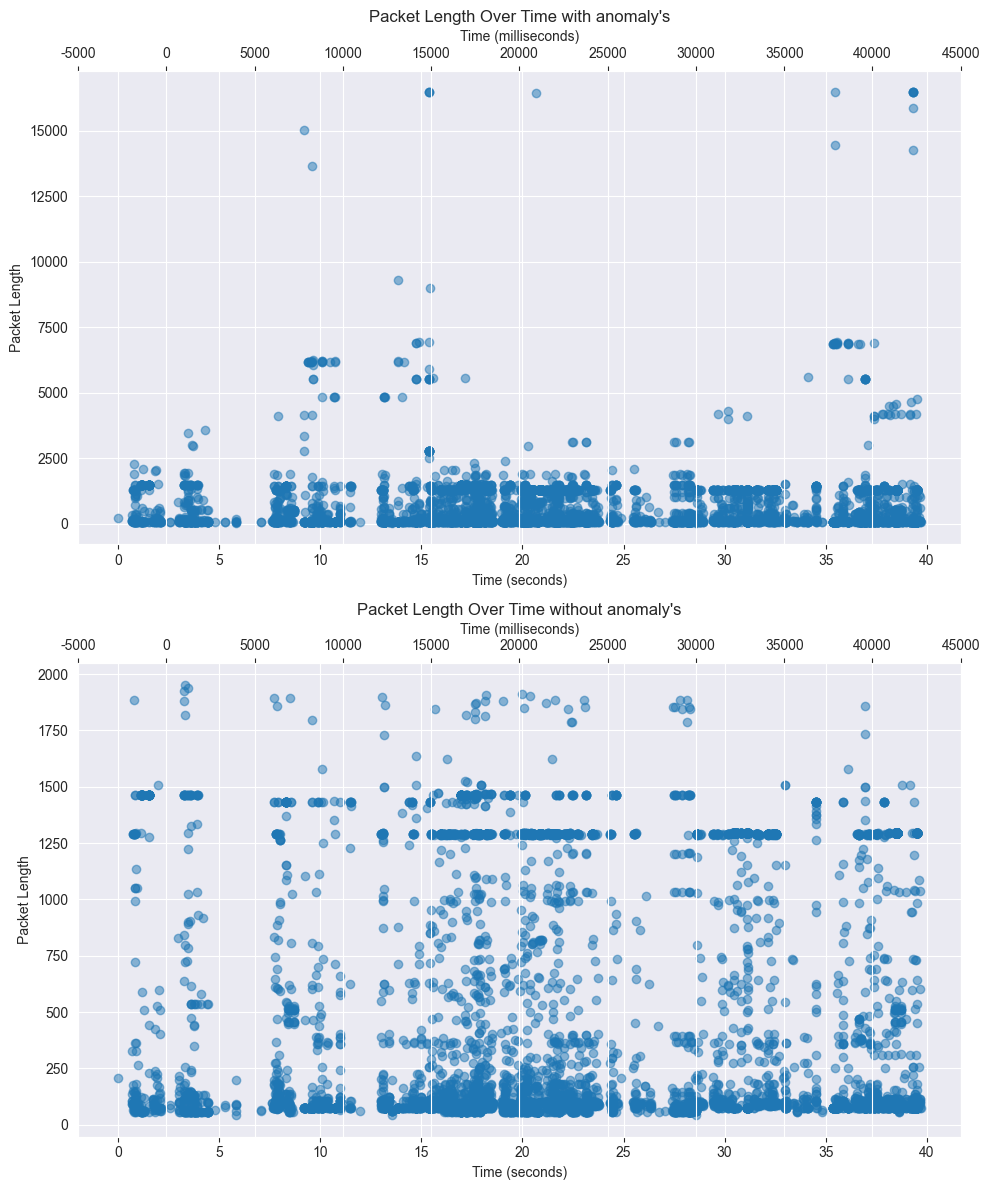

In [91]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Scatter Plot for all data
ax1.scatter(web_surfing_chrome['Time'].dt.total_seconds(), web_surfing_chrome['Length'], alpha=0.5)
ax1.set_title("Packet Length Over Time with anomaly's")
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Packet Length')

# Create a secondary x-axis for milliseconds
ax1_sec = ax1.twiny()
ax1_sec.set_xlim(ax1.get_xlim())
ax1_sec.set_xlabel('Time (milliseconds)')
ax1_sec.set_xticks(ax1.get_xticks())
ax1_sec.set_xticklabels([int(x * 1000) for x in ax1.get_xticks()])

# Filter data to ignore cases where packet length is larger than 2000
filtered_data = web_surfing_chrome[web_surfing_chrome['Length'] <= 2000]

# Scatter Plot for filtered data
ax2.scatter(filtered_data['Time'].dt.total_seconds(), filtered_data['Length'], alpha=0.5)
ax2.set_title("Packet Length Over Time without anomaly's")
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Packet Length')

# Create a secondary x-axis for milliseconds
ax2_sec = ax2.twiny()
ax2_sec.set_xlim(ax2.get_xlim())
ax2_sec.set_xlabel('Time (milliseconds)')
ax2_sec.set_xticks(ax2.get_xticks())
ax2_sec.set_xticklabels([int(x * 1000) for x in ax2.get_xticks()])

plt.tight_layout()
plt.show()

In the packets length we see also vary of length's over time that fits to web surfing.

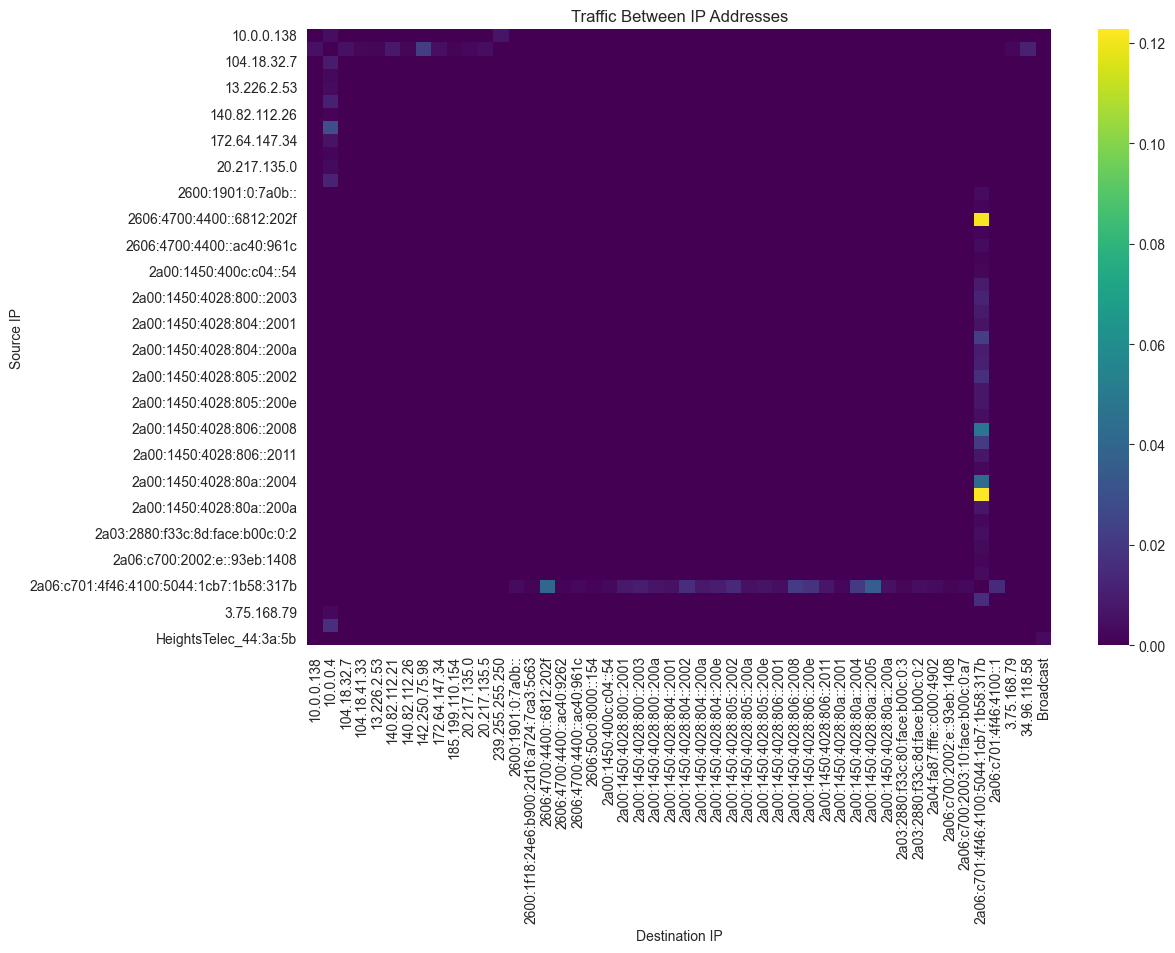

In [92]:
# Calculate the total traffic
total_traffic = web_surfing_chrome.shape[0]

# Create the crosstab
heatmap_data = pd.crosstab(web_surfing_chrome['Source'], web_surfing_chrome['Destination'])

# Filter out addresses with traffic less than 0.01% of the total
threshold = total_traffic * 0.001
filtered_heatmap_data = heatmap_data[heatmap_data > threshold].dropna(axis=0, how='all').dropna(axis=1, how='all')

# Calculate the ratio for each cell
ratio_heatmap_data = filtered_heatmap_data / total_traffic

# Fill NaN values with their real ratio
filled_heatmap_data = ratio_heatmap_data.fillna(0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filled_heatmap_data, cmap='viridis')
plt.title('Traffic Between IP Addresses')
plt.xlabel('Destination IP')
plt.ylabel('Source IP')
plt.show()

In the IP heatmap we can see that there is one major IP address that sent and receive messages that we assume this the record computer IP address.

### Web Surfing Edge:

In [93]:
from datetime import datetime, timedelta

# Read the CSV file into a DataFrame
web_surfing_edge = pd.read_csv('web_surfing_2_edge.csv')

# Convert the 'Time' column to datetime with the correct format
web_surfing_edge['Time'] = pd.to_datetime(web_surfing_edge['Time'], format='%Y/%j %H:%M:%S.%f')

# Calculate the time difference from the start of the recording
start_time = web_surfing_edge['Time'].iloc[0]
web_surfing_edge['Time'] = web_surfing_edge['Time'] - start_time

# Convert the time difference to timedelta and format it
web_surfing_edge['Time'] = web_surfing_edge['Time'].apply(lambda x: timedelta(seconds=x.total_seconds()))

# Display the updated DataFrame
web_surfing_edge.head()

No.                   Time                                   Source  \
0    1        0 days 00:00:00  2a06:c701:4f46:4100:5044:1cb7:1b58:317b   
1    2 0 days 00:00:00.000444              2001:4cd0:dc00:1::684d:ca6b   
2    3 0 days 00:00:00.001446  2a06:c701:4f46:4100:5044:1cb7:1b58:317b   
3    4 0 days 00:00:00.001859  2a06:c701:4f46:4100:5044:1cb7:1b58:317b   
4    5 0 days 00:00:00.002124                   2a00:1450:400c:c0b::bc   

                               Destination Protocol  Length  \
0              2001:4cd0:dc00:1::684d:ca6b      UDP      97   
1  2a06:c701:4f46:4100:5044:1cb7:1b58:317b      UDP      87   
2              2001:4cd0:dc00:1::684d:ca6b      UDP     216   
3              2001:4cd0:dc00:1::684d:ca6b      UDP     216   
4  2a06:c701:4f46:4100:5044:1cb7:1b58:317b      TCP      86   

                                                Info  
0                               61487  >  443 Len=35  
1                               443  >  61487 Len=25  
2                              61487  >  443 Len=154  
3                              61487  >  443 Len=154  
4  5228  >  49765 [ACK] Seq=1 Ack=1 Win=1045 Len=...

In [94]:
web_surfing_edge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25916 entries, 0 to 25915
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   No.          25916 non-null  int64          
 1   Time         25916 non-null  timedelta64[ns]
 2   Source       25916 non-null  object         
 3   Destination  25916 non-null  object         
 4   Protocol     25916 non-null  object         
 5   Length       25916 non-null  int64          
 6   Info         25915 non-null  object         
dtypes: int64(2), object(4), timedelta64[ns](1)
memory usage: 1.4+ MB


In [95]:
web_surfing_chrome.describe()

No.                       Time        Length
count  6994.000000                       6994   6994.000000
mean   3497.500000  0 days 00:00:23.138665099    656.807120
std    2019.138224  0 days 00:00:10.371630297   1104.918279
min       1.000000            0 days 00:00:00     42.000000
25%    1749.250000     0 days 00:00:16.714548     86.000000
50%    3497.500000  0 days 00:00:21.460082500    139.000000
75%    5245.750000     0 days 00:00:31.954198   1292.000000
max    6994.000000     0 days 00:00:39.697814  16480.000000

Like the record of web surfing using Chrome browser, this table didn't give us to moch information on the data distribution.

In [96]:
# Group by 'Length', count the occurrences, and sort in descending order
result_edge = web_surfing_edge.groupby('Length').size().sort_values(ascending=False)

result_edge

Length
1292    5469
54      1965
1465    1856
74      1800
60      1284
        ... 
687        1
683        1
681        1
1313       1
1052       1
Length: 1453, dtype: int64

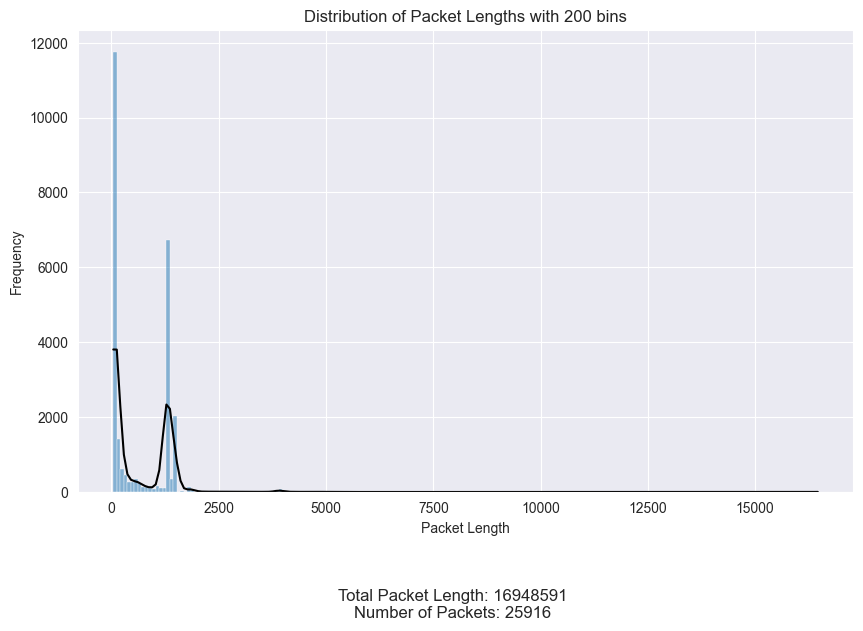

In [97]:
# Replace infinite values with NaN
web_surfing_edge.replace([float('inf'), -float('inf')], float('nan'), inplace=True)

# Calculate the total sum of packet lengths and the number of packets
total_packet_length = web_surfing_edge['Length'].sum()
number_of_packets = web_surfing_edge['Length'].count()

# Create the histogram with KDE
plt.figure(figsize=(10, 6))
ax = sns.histplot(web_surfing_edge['Length'], bins=200, kde=True)

# Set the color of the KDE line to black
for line in ax.lines:
    line.set_color('black')

plt.title('Distribution of Packet Lengths with 200 bins')
plt.xlabel('Packet Length')
plt.ylabel('Frequency')

# Add text below the plot
plt.figtext(0.5, -0.1, f'Total Packet Length: {int(total_packet_length)}\nNumber of Packets: {number_of_packets}',
            ha='center', fontsize=12)

plt.show()

We can see from this histogram and from the table above that most of the packets are relatively small, but in difference from Chrome browser we can see that we use more packets with high length, but still most of the packets are with small amounts of bytes.

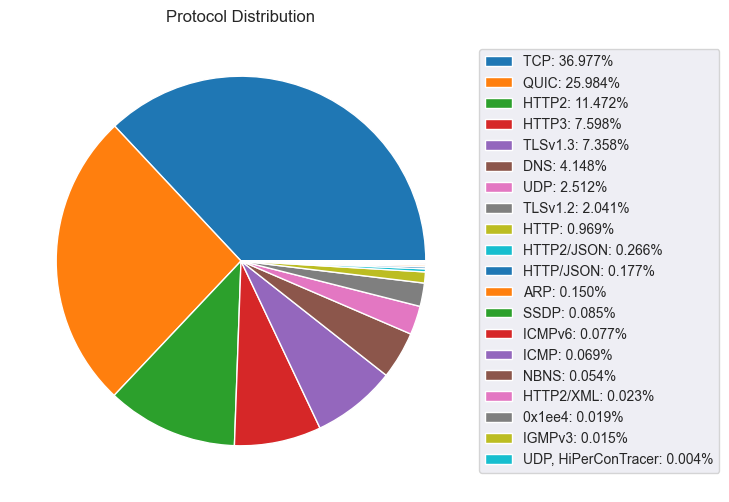

In [98]:
# Calculate protocol counts and their percentages
protocol_counts = web_surfing_edge['Protocol'].value_counts()
protocol_percentages = protocol_counts / protocol_counts.sum() * 100

# Sort the protocol counts by percentage
sorted_protocols = protocol_percentages.sort_values(ascending=False)

# Create the pie chart
plt.figure(figsize=(10, 6))
ax = sorted_protocols.plot.pie(autopct=None, labels=['']*len(sorted_protocols))

# Add a legend with sorted protocol names and percentages
legend_labels = [f'{protocol}: {percentage:.3f}%' for protocol, percentage in sorted_protocols.items()]
ax.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Protocol Distribution')
plt.ylabel('')
plt.show()

This chart is very similar to the web surfing with Chrome browser, but now we see some difference, like in edge we use more on TCP then QUIQ, and we use some UDP as well, we also reduce the amount of TLS although the number of TCP packets is raised.

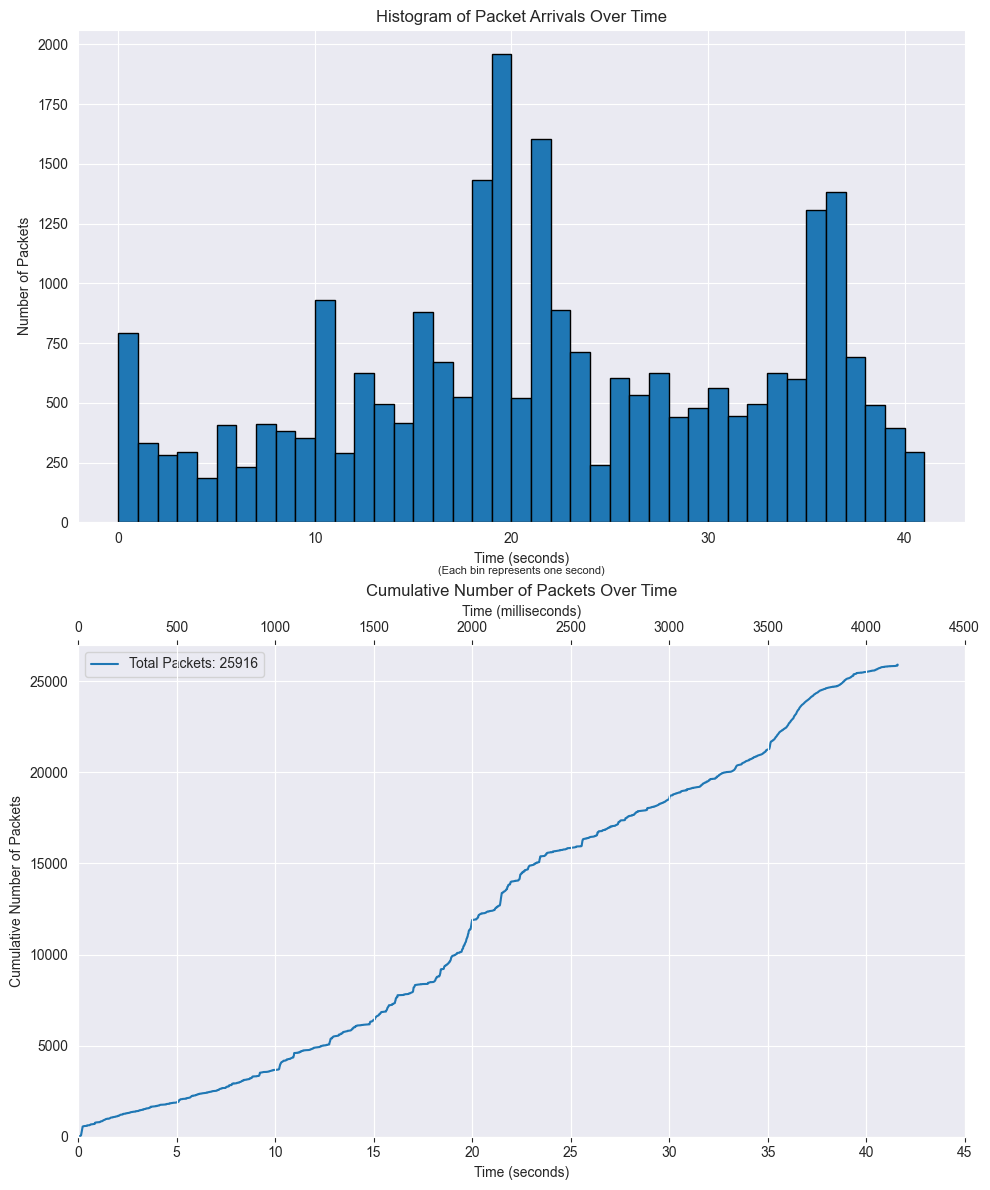

In [99]:
# Ensure 'Time' column is correctly referenced
if 'Time' in web_surfing_edge.columns:
    # Create a copy of the DataFrame for plotting
    plot_data = web_surfing_edge.copy()

    # Set the 'Time' column as the index in the copy
    plot_data.set_index('Time', inplace=True)

    # Convert 'Time' index to milliseconds and seconds
    plot_data['Time_ms'] = plot_data.index.total_seconds() * 1000
    plot_data['Time_s'] = plot_data.index.total_seconds()

    # Sort the index
    plot_data.sort_index(inplace=True)

    # Calculate the cumulative count of packets
    plot_data['Cumulative_Count'] = range(1, len(plot_data) + 1)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Plot the histogram of packet arrivals with bins of 1 second
    ax1.hist(plot_data['Time_s'], bins=range(0, int(plot_data['Time_s'].max()) + 1), edgecolor='black')
    ax1.set_title('Histogram of Packet Arrivals Over Time')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Number of Packets')
    ax1.text(0.5, -0.1, '(Each bin represents one second)', ha='center', va='center', transform=ax1.transAxes, fontsize=8)

    # Plot the cumulative count of packets
    ax2.plot(plot_data['Time_s'], plot_data['Cumulative_Count'], label='Cumulative Count')
    ax2.set_title('Cumulative Number of Packets Over Time')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Cumulative Number of Packets')
    ax2.set_xlim(0, 45)
    ax2.set_ylim(0, 27000)
    total_packets = plot_data['Cumulative_Count'].max()
    ax2.legend([f'Total Packets: {total_packets}'])

    # Create a secondary x-axis for milliseconds
    ax2_sec = ax2.twiny()
    ax2_sec.set_xlim(0, 4500)
    ax2_sec.set_xlabel('Time (milliseconds)')

    # Display the plots
    plt.tight_layout()
    plt.show()
else:
    print("The 'Time' column is not found in the DataFrame.")

Here like in Chrome use we some linear growth in the number uf packets overtime without any particular anomaly's. we see a larger growth in some seconds, we assume in these seconds we open a new site.

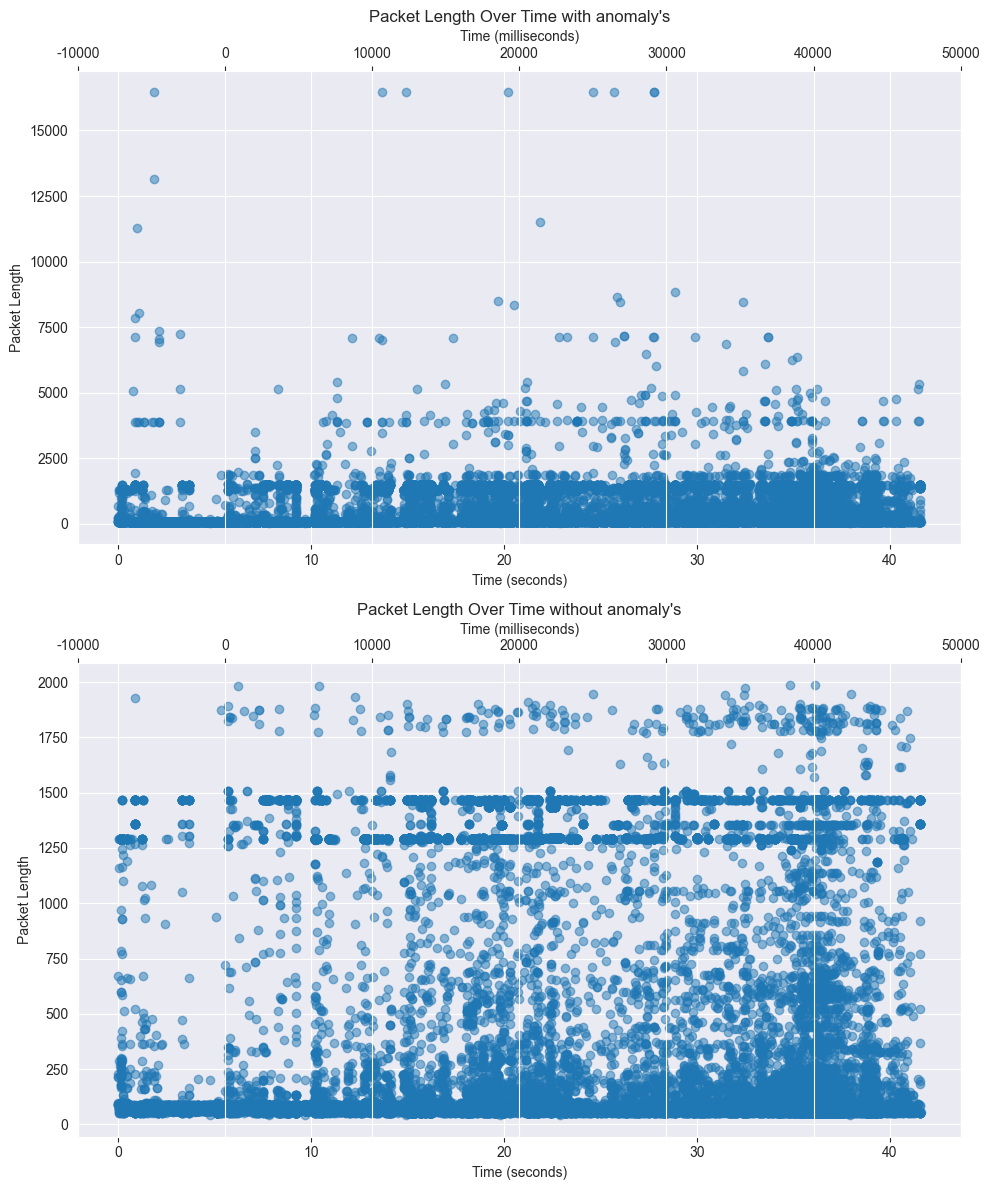

In [100]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Scatter Plot for all data
ax1.scatter(web_surfing_edge['Time'].dt.total_seconds(), web_surfing_edge['Length'], alpha=0.5)
ax1.set_title("Packet Length Over Time with anomaly's")
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Packet Length')

# Create a secondary x-axis for milliseconds
ax1_sec = ax1.twiny()
ax1_sec.set_xlim(ax1.get_xlim())
ax1_sec.set_xlabel('Time (milliseconds)')
ax1_sec.set_xticks(ax1.get_xticks())
ax1_sec.set_xticklabels([int(x * 1000) for x in ax1.get_xticks()])

# Filter data to ignore cases where packet length is larger than 2000
filtered_data = web_surfing_edge[web_surfing_edge['Length'] <= 2000]

# Scatter Plot for filtered data
ax2.scatter(filtered_data['Time'].dt.total_seconds(), filtered_data['Length'], alpha=0.5)
ax2.set_title("Packet Length Over Time without anomaly's")
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Packet Length')

# Create a secondary x-axis for milliseconds
ax2_sec = ax2.twiny()
ax2_sec.set_xlim(ax2.get_xlim())
ax2_sec.set_xlabel('Time (milliseconds)')
ax2_sec.set_xticks(ax2.get_xticks())
ax2_sec.set_xticklabels([int(x * 1000) for x in ax2.get_xticks()])

plt.tight_layout()
plt.show()

Here we see that there is diversity of the packets length over the time, we cant conclude there is some bytes length we use to transport the data.

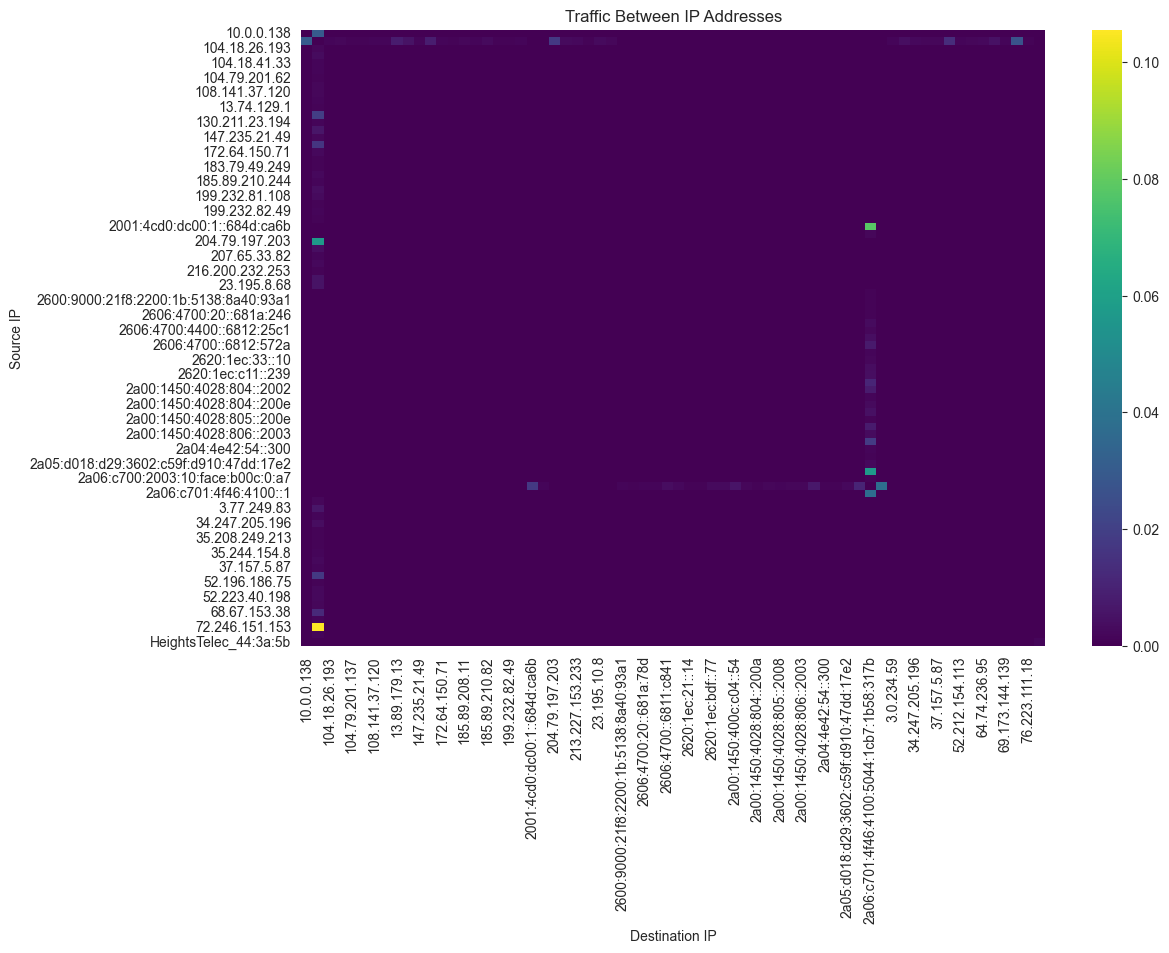

In [101]:
# Calculate the total traffic
total_traffic = web_surfing_edge.shape[0]

# Create the crosstab
heatmap_data = pd.crosstab(web_surfing_edge['Source'], web_surfing_edge['Destination'])

# Filter out addresses with traffic less than 0.001% of the total
threshold = total_traffic * 0.001
filtered_heatmap_data = heatmap_data[heatmap_data > threshold].dropna(axis=0, how='all').dropna(axis=1, how='all')

# Calculate the ratio for each cell
ratio_heatmap_data = filtered_heatmap_data / total_traffic

# Fill NaN values with their real ratio
filled_heatmap_data = ratio_heatmap_data.fillna(0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filled_heatmap_data, cmap='viridis')
plt.title('Traffic Between IP Addresses')
plt.xlabel('Destination IP')
plt.ylabel('Source IP')
plt.show()

Like in Chrome surfing we can see there is one major address that all the address's talk with it.

> **Important distinction:**<br>
> We can see that web surfing using Chrome browser and web surfing using Edge browser give similar results, so we assume that model cannot recognize if it Chrome web surfing or Edge web surfing, but we will try it in the model notebook.

## Analyze all together

Because the packet length per time (the dots plot) and the packet length distribution is very similar we only compare the protocols distribution and the cumulative number of packets over time

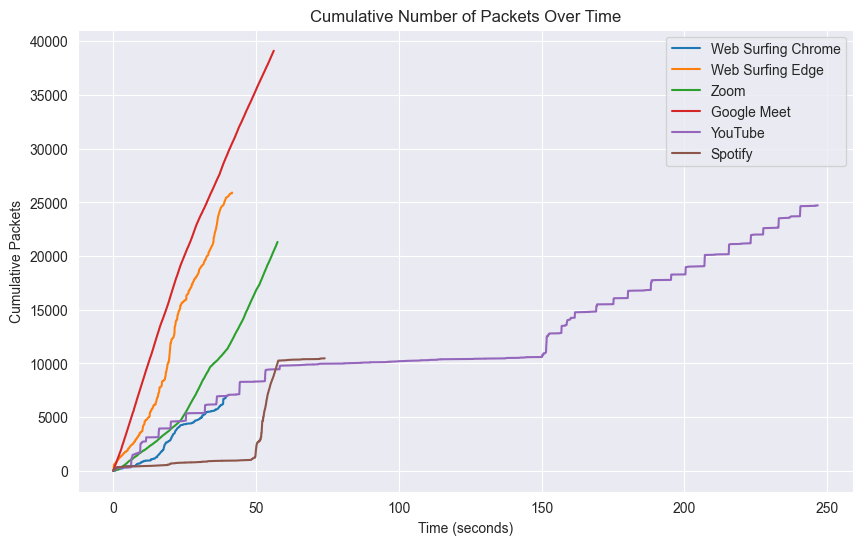

In [102]:
# Define your datasets in a dictionary with a descriptive label
datasets = {
    'Web Surfing Chrome': web_surfing_chrome,
    'Web Surfing Edge' : web_surfing_edge,
    'Zoom': video_conference_zoom,
    'Google Meet': video_conference_google_meet,
    'YouTube': video_streaming_youtube,
    'Spotify' : audio_streaming_spotify
}

# Create figure and axis for the combined plot
fig, ax = plt.subplots(figsize=(10, 6))

for label, df in datasets.items():
    if 'Time' in df.columns:
        # Sort data by Time
        df_sorted = df.sort_values(by='Time')

        # Convert 'Time' column to seconds. If 'Time' is already a timedelta, use total_seconds()
        time_seconds = df_sorted['Time'].dt.total_seconds()  # assuming datetime or timedelta
        cumulative_counts = range(1, len(df_sorted) + 1)

        # Plot cumulative count versus time in seconds
        ax.plot(time_seconds, cumulative_counts, label=label)

ax.set_title('Cumulative Number of Packets Over Time')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Cumulative Packets')
ax.legend()
plt.show()

We can see that the fastest growth of packets is video conferencing using Google Meet (grow exponentially over time), after this is we can see the web surfing using Edge browser, and then we can notice video conferencing using zoom, the simple explanation is that Google meet and Edge browser using mostly with TCP connection while zoom using UDP and Chrome using mostly with QUIQ, all of that reduce the number of packets in the network and help the congestion control of the network.<br>The audio streaming and the video streaming act a little different, the data is sent in regular time periods, and we get approximately the same amount od data each period

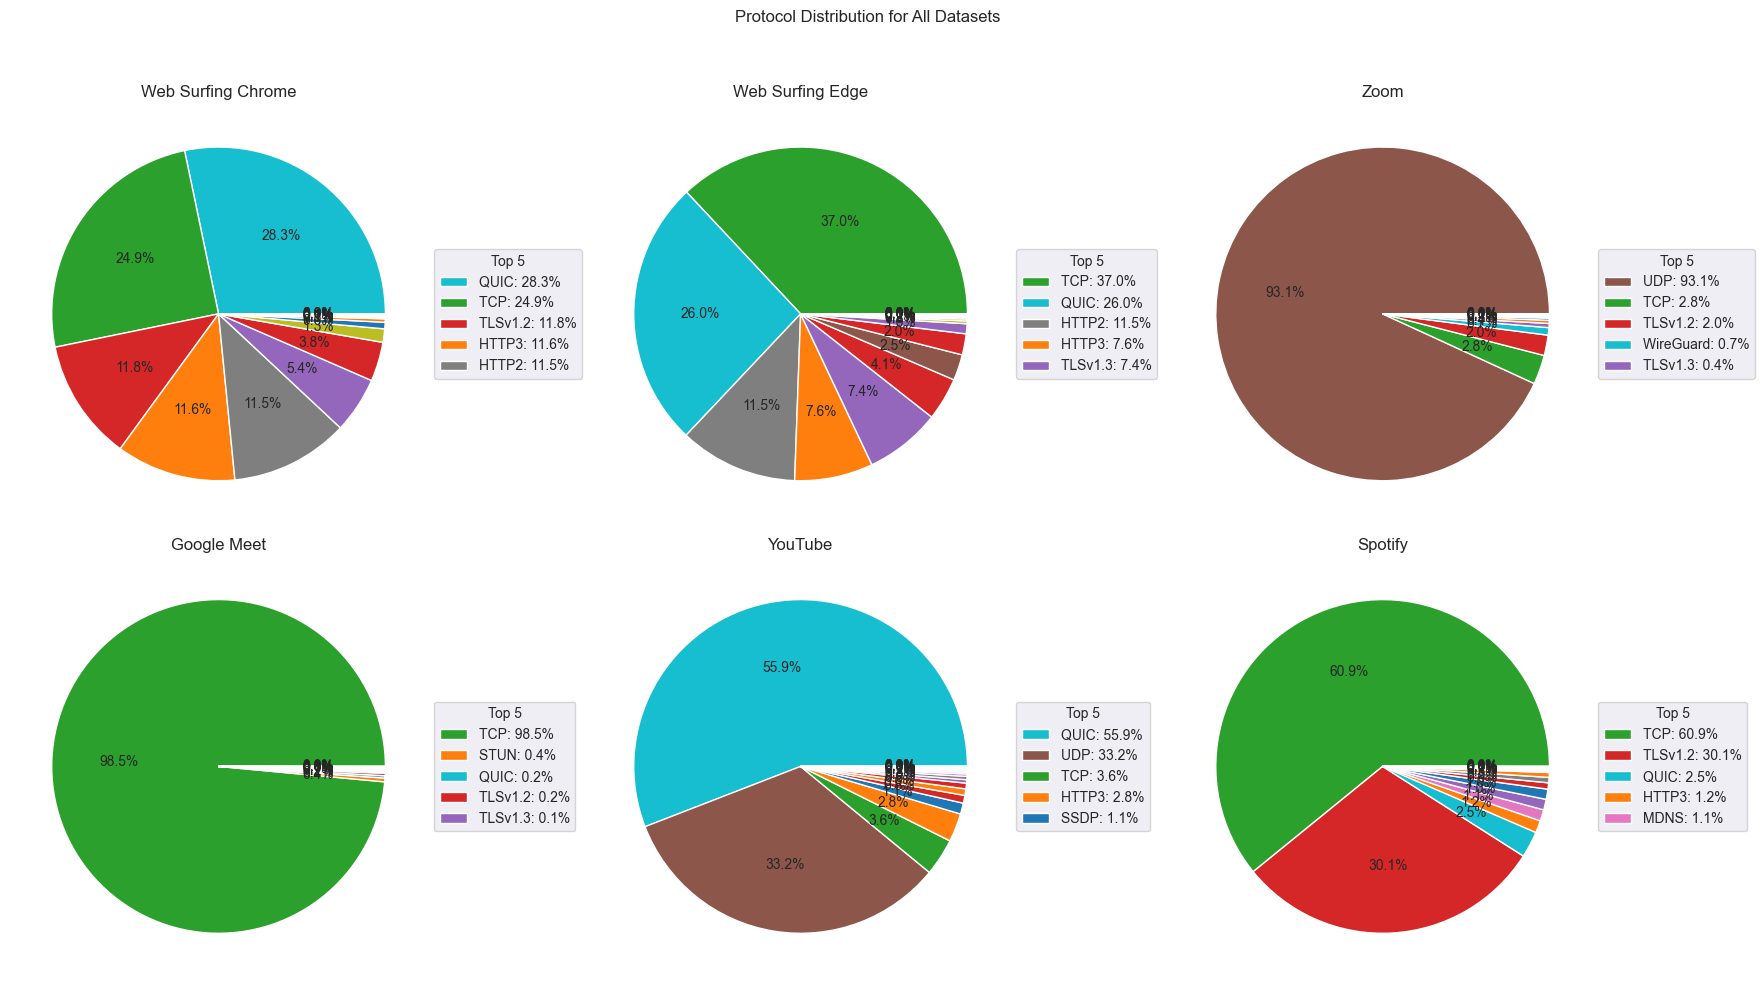

In [103]:
# Define the datasets dictionary
datasets = {
    'Web Surfing Chrome': web_surfing_chrome,
    'Web Surfing Edge': web_surfing_edge,
    'Zoom': video_conference_zoom,
    'Google Meet': video_conference_google_meet,
    'YouTube': video_streaming_youtube,
    'Spotify': audio_streaming_spotify
}

# Get a set of all protocols present in the datasets.
all_protocols = set()
for df in datasets.values():
    if 'Protocol' in df.columns:
        all_protocols.update(df['Protocol'].dropna().unique())

# Create a color mapping for the protocols using a colormap.
cmap = plt.get_cmap('tab10')
protocol2color = {}
for idx, protocol in enumerate(sorted(all_protocols)):
    protocol2color[protocol] = cmap(idx % 10)

# Create a subplot grid (2 rows, 3 columns)
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

# Loop through each dataset
for ax, (name, df) in zip(axs, datasets.items()):
    if 'Protocol' in df.columns:
        # Calculate protocol percentages
        protocol_counts = df['Protocol'].value_counts()
        protocol_percentages = protocol_counts / protocol_counts.sum() * 100
        sorted_protocols = protocol_percentages.sort_values(ascending=False)
        # Extract top five protocols for the legend
        top_five = sorted_protocols.head(5)

        # Use global colors for the protocols present in this dataset
        colors = [protocol2color.get(protocol, '#333333') for protocol in sorted_protocols.index]

        # Create pie chart with empty labels
        wedges, texts, autotexts = ax.pie(sorted_protocols, labels=[''] * len(sorted_protocols),
                                            autopct='%1.1f%%', colors=colors)
        # Build legend labels with top five protocols and corresponding color patches
        legend_labels = [f"{protocol}: {percentage:.1f}%" for protocol, percentage in top_five.items()]
        legend_colors = [protocol2color.get(protocol, '#333333') for protocol in top_five.index]
        # Add legend to the side
        ax.legend(wedges, legend_labels, title="Top 5", loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        # Handle missing 'Protocol' column
        ax.text(0.5, 0.5, "Protocol column missing", ha='center', va='center')
        ax.axis('off')

    ax.set_title(name)

plt.suptitle('Protocol Distribution for All Datasets')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

We can infer from these charts that still most of the data will transfer using TCP, but there is some trend of changing the transfer protocol of data from TCP to QUIQ, we can see the most powerful change in YouTube, although it video strengthen it still use QUIQ more than UDP, and in web surfing we can see trend of more sending data using QUIQ, and in Chrome browser we can see more use with QUIQ then with TCP.<br>We can see also that Google Meet using only TCP for transport instead of UDP, and we explain it above.

## Conclusion

In this notebook, we performed an extensive analysis to identify the unique characteristics of major network activities. For each activity, we examined several critical aspects:

- A basic understanding of the data distribution was gained using functions such as `info()` and `describe()`, along with specific aggregations using `groupby()` when necessary.
- The distribution of packet bytes lengths was analyzed to highlight typical sizes for video, audio, and control data.
- Protocol distribution was explored to determine the prevalence of UDP versus TCP transmissions, revealing unexpected usage patterns—such as the discovery that Google Meet relies on TCP despite initial assumptions that it used UDP.
- Packet time arrival distributions were scrutinized to reveal both constant and variable arrival rates, shedding light on connection establishment periods and steady-state data transfer.
- Correlations between packet length and arrival time were investigated to understand how the timing of packets reflects specific application behaviors.
- Finally, the patterns in IP source and destination distributions were examined using cross-tabulations and heatmaps, which underscored the point-to-point nature of most communications and highlighted areas of concentrated traffic.

Our observations indicate that each network activity exhibits unique characteristics. For example, while video streaming is often assumed to rely primarily on UDP, our in-depth analysis shows that applications like Google Meet actually employ TCP protocols due to their browser-based implementations. Additionally, distinct packet arrival patterns and variations in packet byte lengths underscore fundamental differences at the application level. These differences can be correlated with the underlying network layers and emergent behaviors observed in real-world usage.

Moreover, although background processes introduce their own signatures in the collected data, careful investigation allowed us to isolate and analyze the primary network behavior without the interference of this noise. Overall, the systematic approach adopted in this notebook reinforces the idea that both theoretical models and empirical observations are essential to understanding modern network communications.